In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/SEOP-and-NMR.git

# add path to .py files for import
import sys
sys.path.insert(1, "/content/SEOP-and-NMR/src")

Cloning into 'SEOP-and-NMR'...
remote: Enumerating objects: 505, done.
remote: Counting objects: 100% (505/505), done.
remote: Compressing objects: 100% (444/444), done.
remote: Total 505 (delta 286), reused 131 (delta 52), pack-reused 0
Receiving objects: 100% (505/505), 9.41 MiB | 3.77 MiB/s, done.
Resolving deltas: 100% (286/286), done.


In [2]:
# PYTHON PACKAGES
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import inv
import matplotlib.pyplot as plt
import copy as cp
np.random.seed(14)

# MY PACKAGES
import physical_constant_units as phy
import measurements as meas
import environment as env
import xenon as xe
import utils

/content/SEOP-and-NMR/src/measurements.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Single specie simulation with magnetic noise ($B_{noise} \neq 0$)

In this simulation we generate magnetic noise and ignore the effective magnetic field of the alkali spin. Then, the phase of the Xenon with respect to the drive is given by

\begin{align}
    \phi_{129} &= -\frac{\gamma^{129}_{Xe}B_0}{\Gamma_2^{129}}-\frac{\gamma^{129}_{Xe}B_{noise}}{\Gamma_2^{129}}-\frac{\omega_r}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}}{\Gamma_2^{129}}
\end{align}


### Solve and plot results

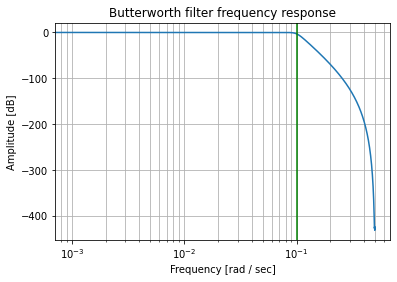

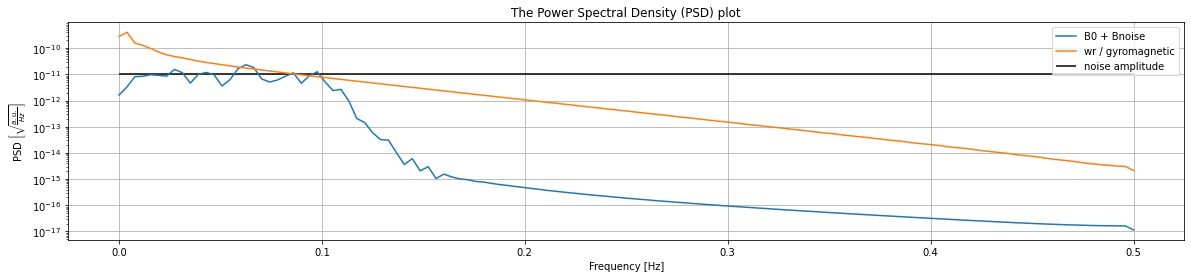

In [3]:
# solver and noise parameters
t_final = 300                             # [s]
dt = 1                                      # [s]
sampling_frequency = 1 / dt                 # [Hz]
noise_cutoff_frequency = 0.1                # [Hz]
noise_amplitude = 1e-7 * phy.G2T            # [Tesla]
steps = int(t_final // dt)
ts1 = np.linspace(0, dt, 2)                 # [s]
ts = np.linspace(0, t_final, steps)         # [s]
noise = utils.get_white_noise(noise_amplitude, sampling_frequency, ts)  # [Tesla]

# world rotation parameters
# wr = 0.3 * utils.gaussian(ts, 700, 60)                         # rad / s
# wr = utils.ReLU(ts, x0=100, m=0.001)                          # rad / s
wr = 0.01 * utils.sigmoid(ts, 1, 60)                          # rad / s

# Xenon parameters
g129 = phy.G129                        # gyromagnetic ratio [rad  s^-1  T^-1]
t1 = 30                                # s / rad
t2 = 8                                 # s / rad
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

# Environment parameters
B0 = 1e-6 * phy.G2T * np.ones_like(ts)    # Tesla 
Bnoise = utils.butter_low_pass_filter(noise, 10, noise_cutoff_frequency, sampling_frequency, plot_filter=True)
Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
wd_y = g129 * 1e-6 * phy.G2T * np.ones_like(ts)                    # rad / s
Ad_x = np.zeros_like(ts)                                        # rad / s
wd_x = np.zeros_like(ts)                                        # rad / s

# PSD plot of all signals
signal_list = [B0 + Bnoise, wr / g129]
names = ['B0 + Bnoise', 'wr / gyromagnetic']
utils.psd_compare(signal_list, sampling_frequency, noise_amplitude=noise_amplitude, names=names)

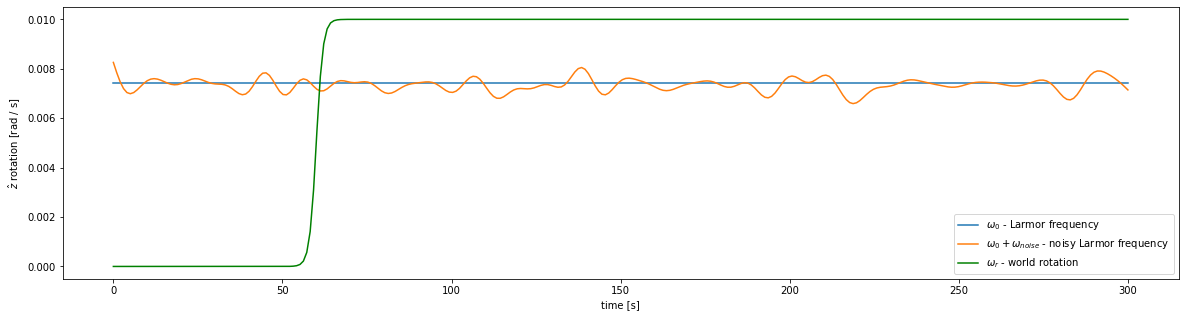

In [4]:
# initialize Xenon
Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse)

# initialize Environment
env129 = env.Environment()
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)

# plot world rotation
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()
ax.plot(ts, -Xe129.gamma * B0, label='$\omega_0$ - Larmor frequency')
ax.plot(ts, -Xe129.gamma * (B0 + Bnoise), label='$\omega_0 + \omega_{noise}$ - noisy Larmor frequency')
ax.plot(ts, wr, label='$\omega_r$ - world rotation', color='green')
ax.set_ylabel('$\hat{z}$ rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
plt.show()

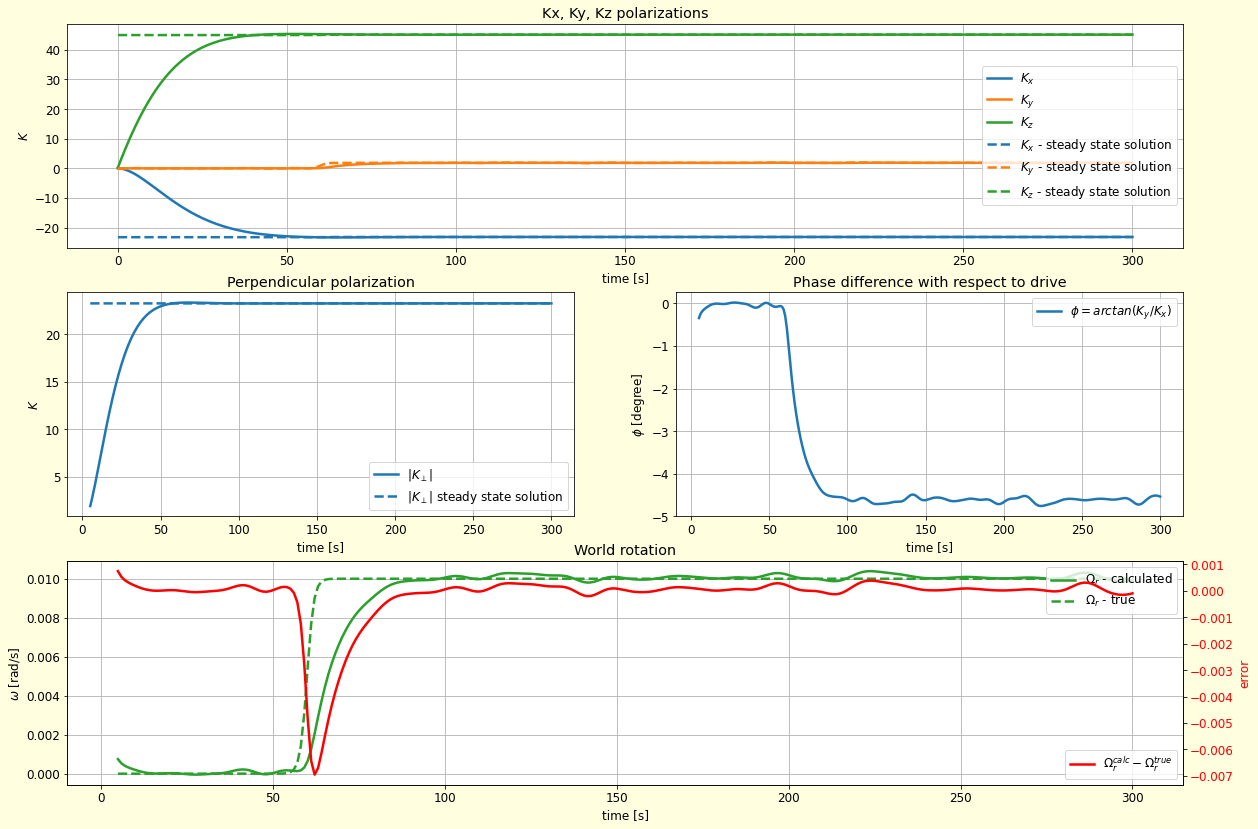

In [5]:
# run solver and save dynamics
#Xe129.init_with_steady_state()
Xe129.solve_dynamics(env129)
Xe129.plot_results(env129, ti=5)

### Dynamic range simulation 

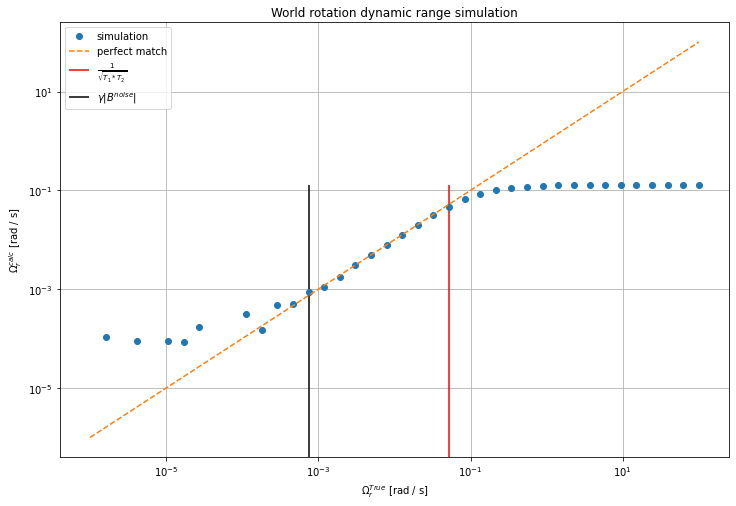

In [11]:
#@title Dynamic range
t1 = 30 #@param {type:"slider", min:1, max:100, step:1}
t2 = 12 #@param {type:"slider", min:1, max:100, step:1}

Xenon_isotop = "129" #@param ["129", "131"]
B_noise_amplitude_gauss = 1e-7 #@param {type:"number"}
B0_amplitude_gauss = 1e-6 #@param {type:"number"}
noise_cutoff_hz = 0.1 #@param {type:"number"}
dt_solver = 0.1 #@param {type:"number"}

if Xenon_isotop == '129':
    gyro = phy.G129
if Xenon_isotop == '131':
    gyro = phy.G131

# pick world rotation amplitudes
wr_amplitudes = np.logspace(-6, 2, 40)

# run experiment
meas.single_species_Open_Loop_dynamic_range_simulation(gyro, 
                                                       t1, 
                                                       t2, 
                                                       wr_amplitudes, 
                                                       B0_amp=B0_amplitude_gauss, 
                                                       Bnoise_amp=B_noise_amplitude_gauss, 
                                                       noise_cutoff_hz=noise_cutoff_hz, 
                                                       filter_order=2, 
                                                       plot_results=True, 
                                                       get_values=False, 
                                                       dt=dt_solver, 
                                                       t_final=400)

So we see that with magnetic noise we can extract the world rotation signal as long as it is larger then the magnetic noise amplitude and smaller then the $\frac{1}{\sqrt{T_1  T_2}}$. In order to extract the world rotation also for small amplitudes which are smaller then the magnetic noise we need to introduce another Xenon species (131) measurement so we can subtruct the magnetic noise from the measured signal. 

steps =  29999
wc =  0.6666666666666666


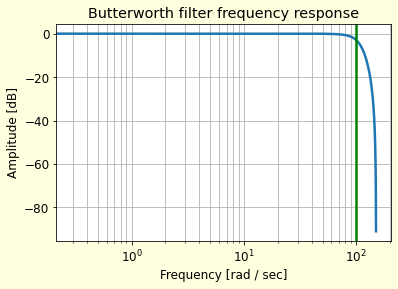

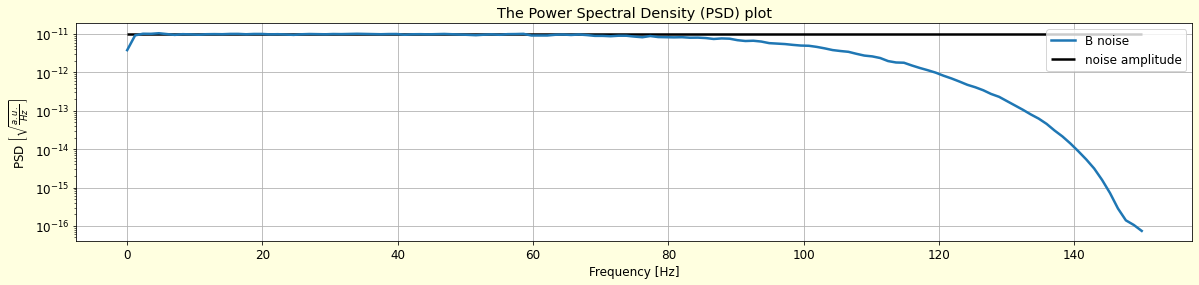

In [27]:
# solver parameters
freq = 0.1                    # [Hz]
period = 1 / freq               # [s]
num_periods = 10
t_final = num_periods * period  # [s]
t2 = 8                                 # s
if t_final < 8 * t2:
    print(t_final, 8 * t2)
    t_final = 8 * t2
dt = period / 3000              # [s]
sampling_frequency = 1 / dt     # [Hz]
steps = int(t_final // dt)
ts = np.linspace(0, t_final, steps)

# magnetic noise
noise_cutoff_frequency = freq * 1e3              # [Hz]
noise_amplitude = 1e-7 * phy.G2T            # [Tesla]
noise = utils.get_white_noise(noise_amplitude, sampling_frequency, ts)  # [Tesla]
print('steps = ', steps)
print('wc = ', noise_cutoff_frequency / (sampling_frequency / 2))



# world rotation parameters
wr = 0.01 * np.sin(2 * np.pi * freq * ts)             # rad / s

# Xenon parameters
g129 = phy.G129                        # gyromagnetic ratio [rad  s^-1  T^-1]
t1 = 30                                # s
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

# Environment parameters
B0 = 1e-6 * phy.G2T * np.ones_like(ts)                             # Tesla
Bnoise = utils.butter_low_pass_filter(noise, 2, noise_cutoff_frequency, sampling_frequency, plot_filter=True)
Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
wd_y = g129 * 1e-6 * phy.G2T * np.ones_like(ts)                    # rad / s
Ad_x = np.zeros_like(ts)                                        # rad / s
wd_x = np.zeros_like(ts)                                        # rad / s


utils.psd_compare([Bnoise], sampling_frequency, noise_amplitude=noise_amplitude, names=['B noise'])

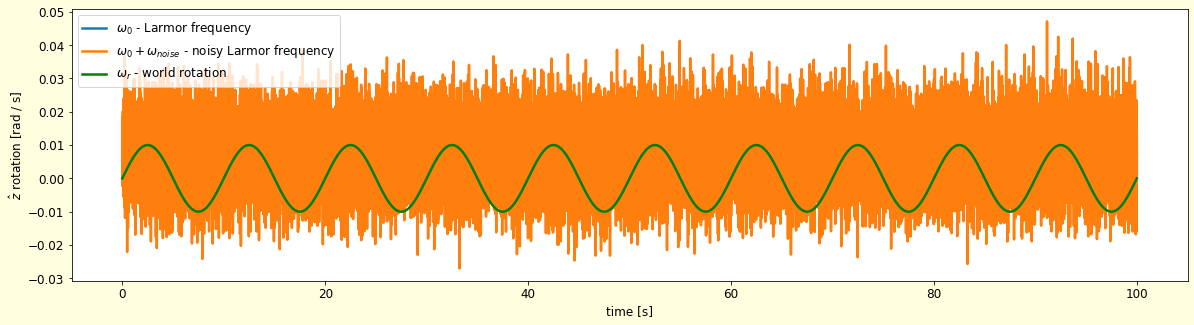

In [25]:
# initialize Xenon
Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse)

# initialize Environment
env129 = env.Environment()
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)

# plot world rotation
fig = plt.figure(figsize=(20, 5))
ax = plt.subplot()
ax.plot(ts, -Xe129.gamma * B0, label='$\omega_0$ - Larmor frequency')
ax.plot(ts, -Xe129.gamma * (B0 + Bnoise), label='$\omega_0 + \omega_{noise}$ - noisy Larmor frequency')
ax.plot(ts, wr, label='$\omega_r$ - world rotation', color='green')
ax.set_ylabel('$\hat{z}$ rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
plt.show()

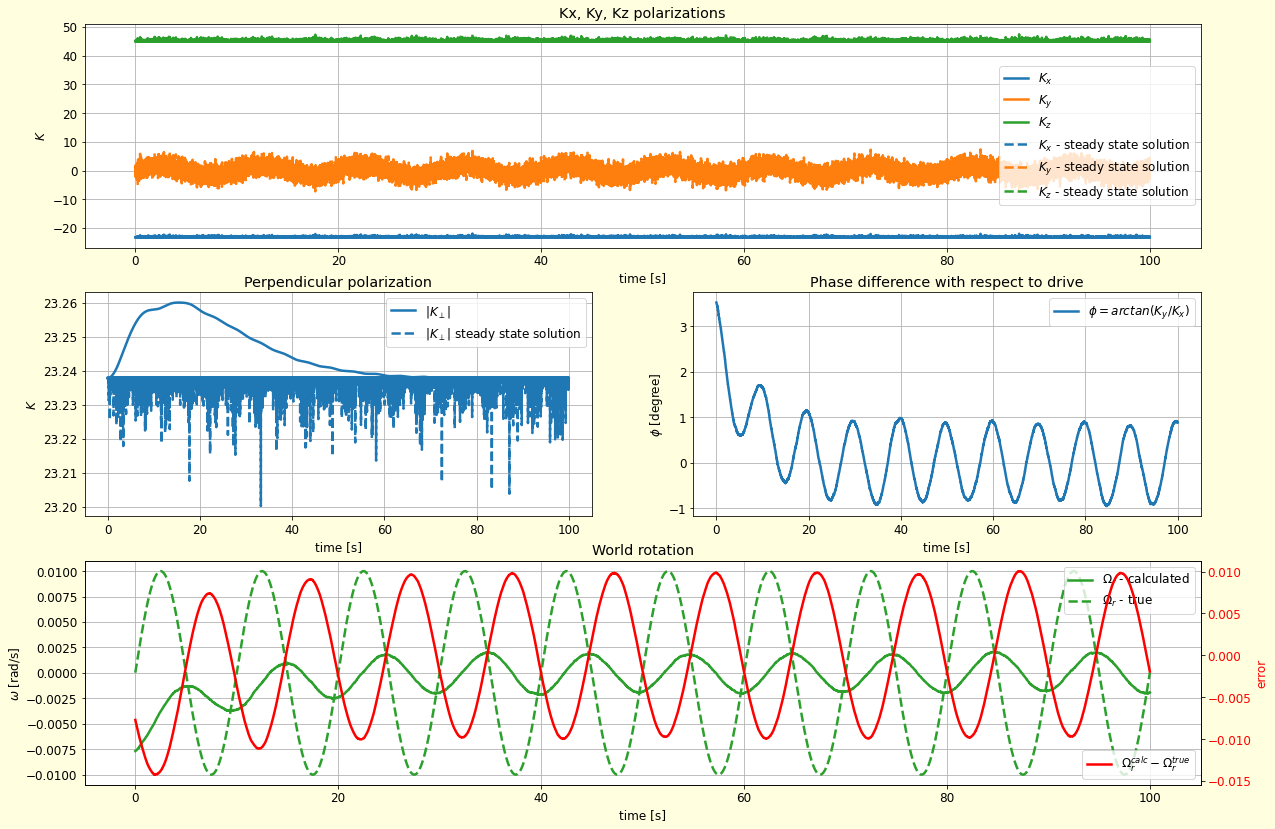

In [26]:
# run solver and save dynamics
Xe129.set_bloch_matrix(env129)
Xe129.init_with_steady_state()
Xe129.solve_dynamics(env129)
Xe129.plot_results(env129)

In [20]:
world_rotation = -Xe129.phase_perp * Xe129.gamma2 + Xe129.gamma * env129.B0 - env129.wd_y
amplitude_ratio = np.max(world_rotation[ts > 8 * t2]) / np.max(wr)
print(np.max(wr))
print(t2)
print(np.max(world_rotation[ts > 8 * t2]))
print(amplitude_ratio)

0.009999999986291303
8
0.010294851539555748
1.029485155366865


[0.0001     0.0001269  0.00016103 0.00020434 0.00025929 0.00032903
 0.00041753 0.00052983 0.00067234 0.00085317 0.00108264 0.00137382
 0.00174333 0.00221222 0.00280722 0.00356225 0.00452035 0.00573615
 0.00727895 0.00923671 0.01172102 0.01487352 0.01887392 0.02395027
 0.03039195 0.0385662  0.04893901 0.06210169 0.07880463 0.1       ]



freq: 0.0001, steps: 5999, fs: 0.3


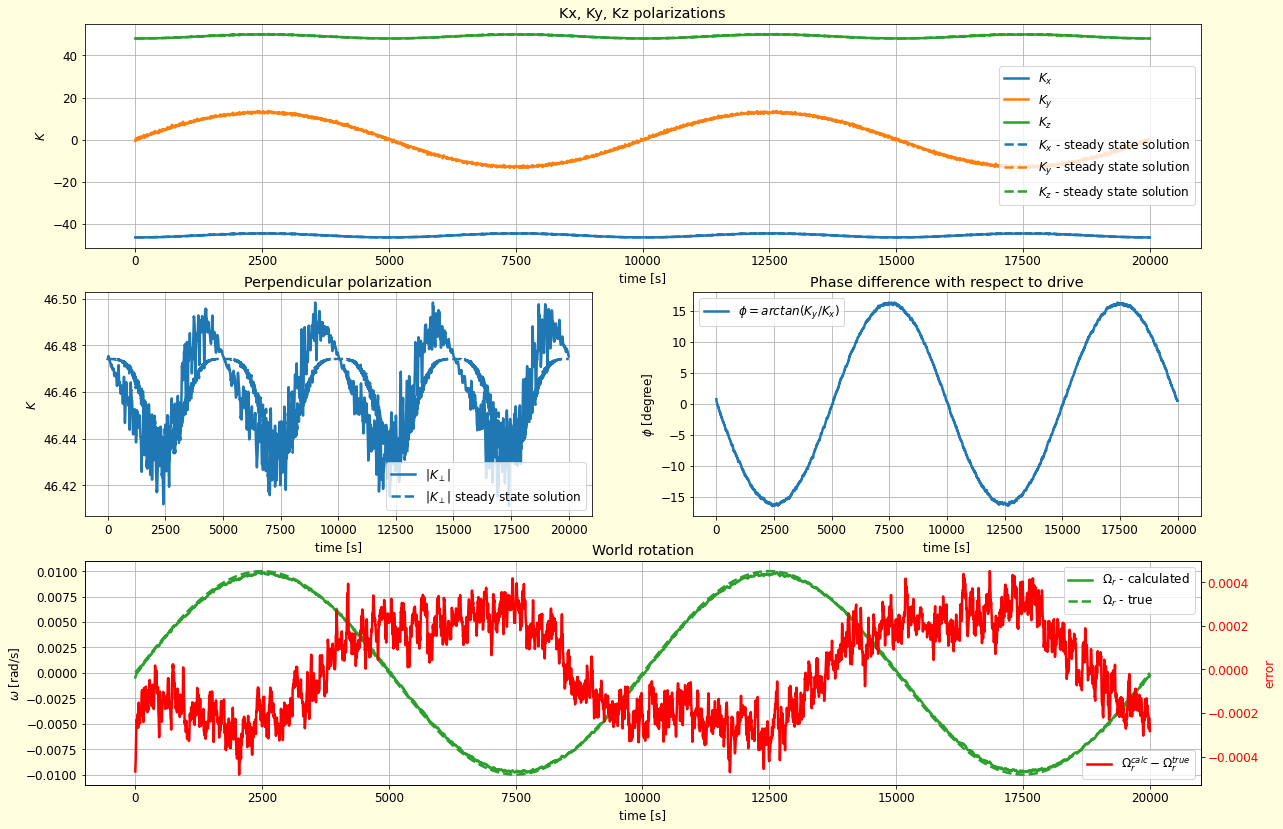


freq: 0.0001268961003167922, steps: 6000, fs: 0.38068830095037665


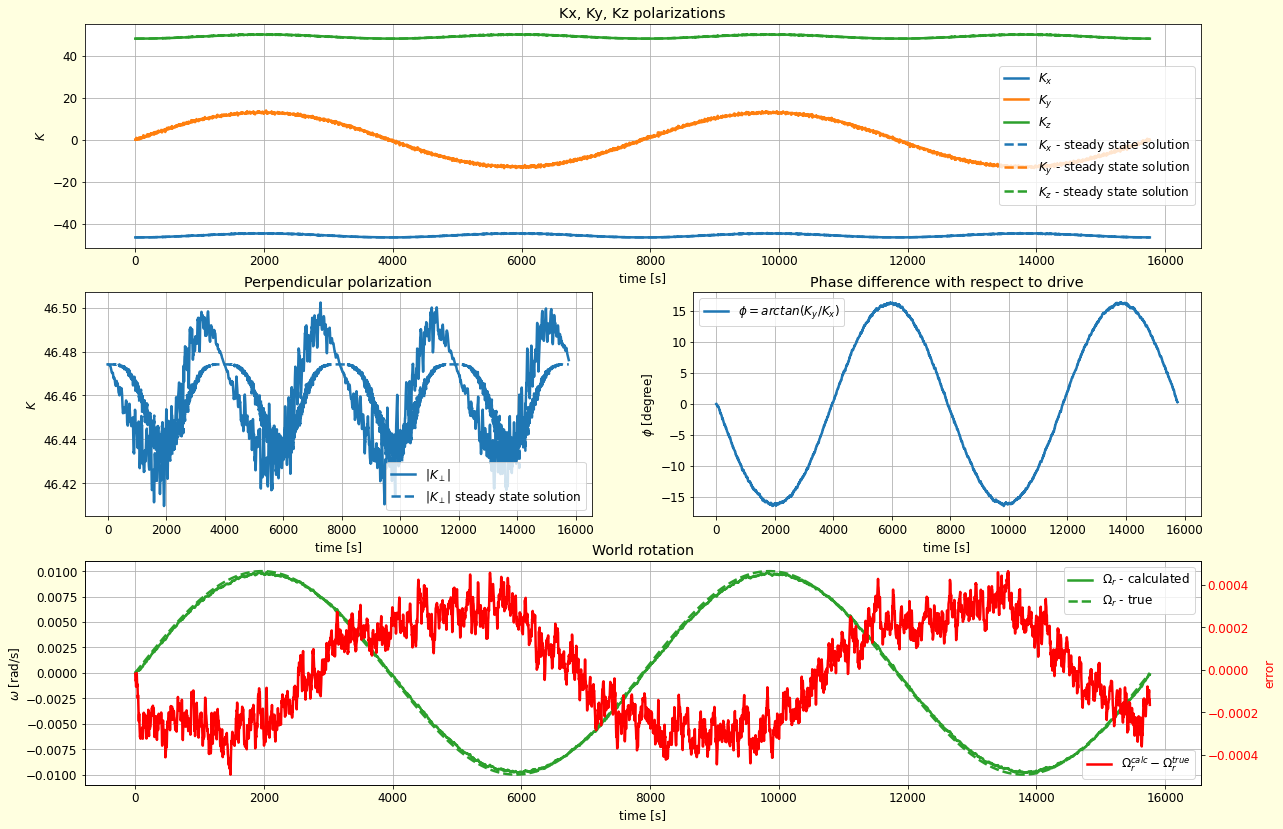


freq: 0.00016102620275609394, steps: 5999, fs: 0.4830786082682818


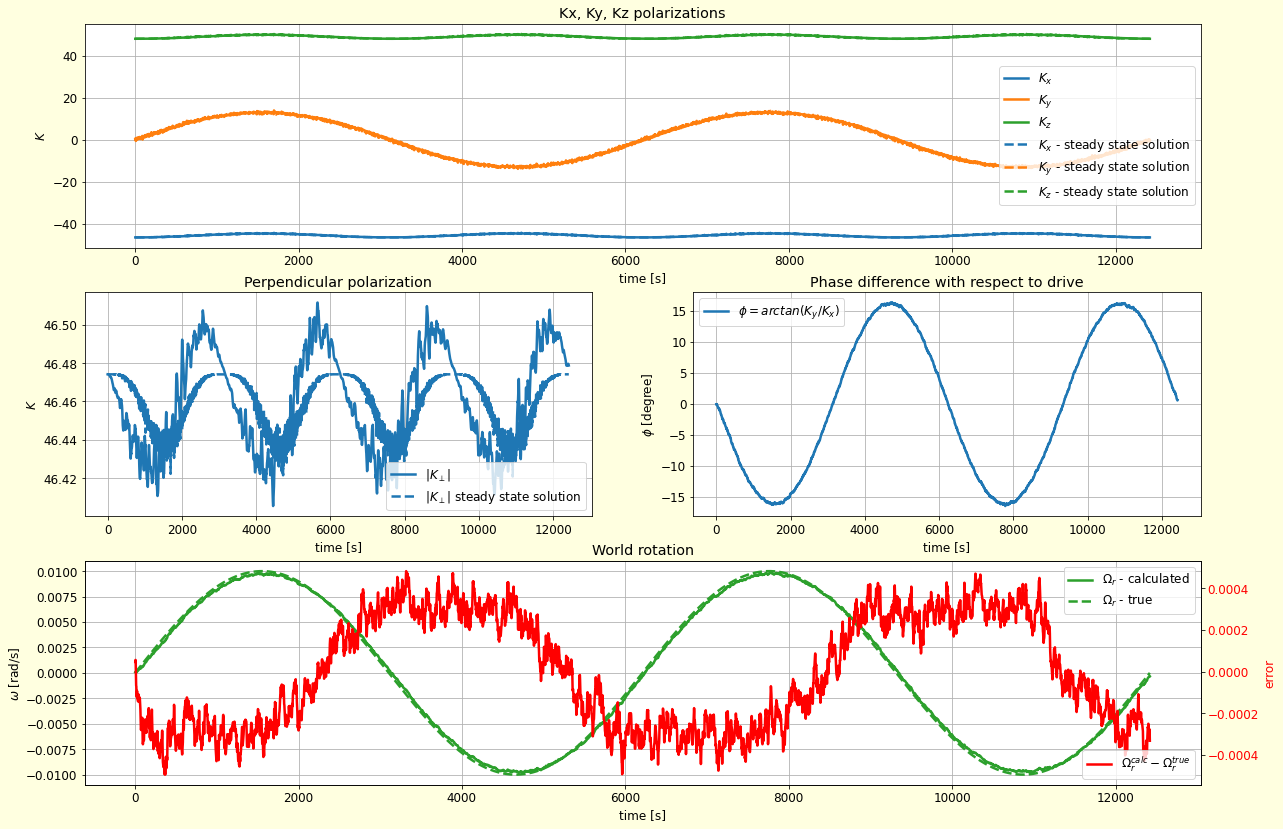


freq: 0.00020433597178569417, steps: 6000, fs: 0.6130079153570825


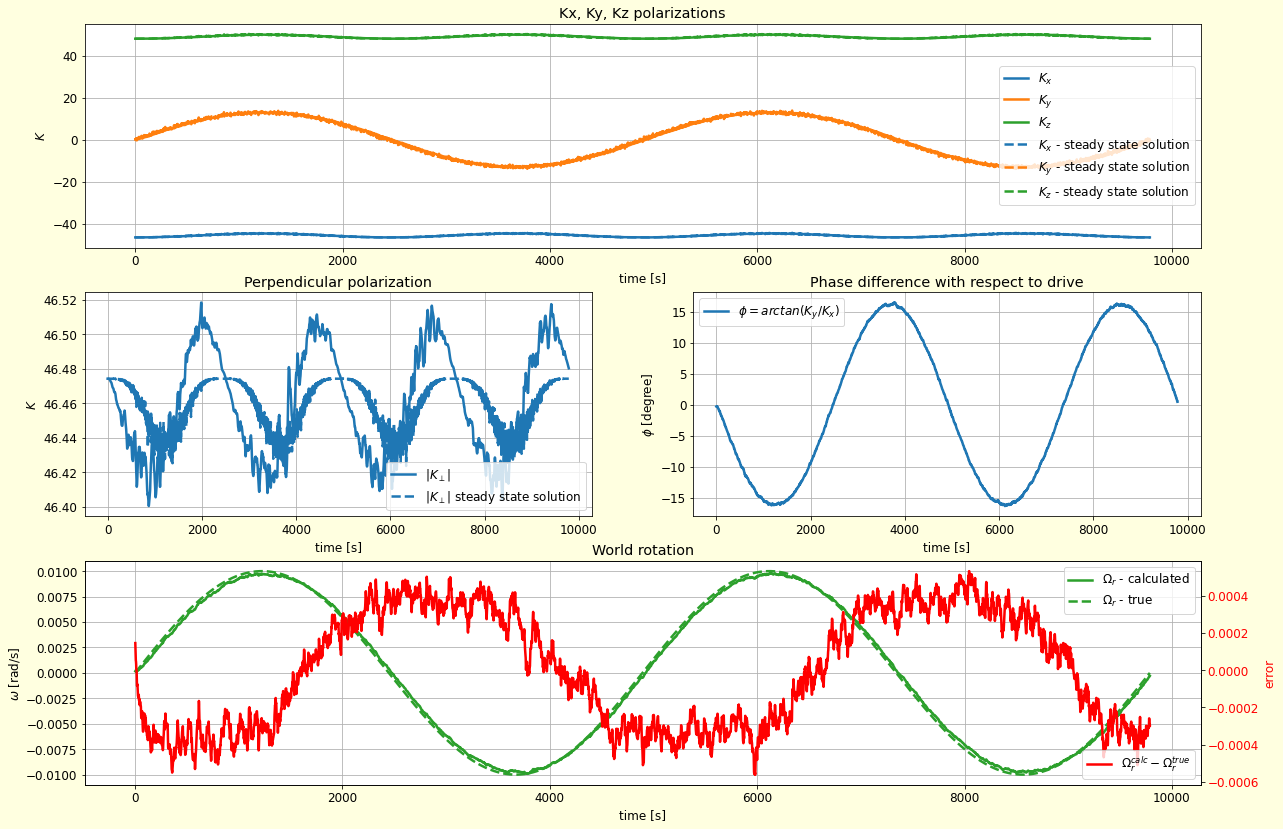


freq: 0.0002592943797404667, steps: 5999, fs: 0.7778831392214001


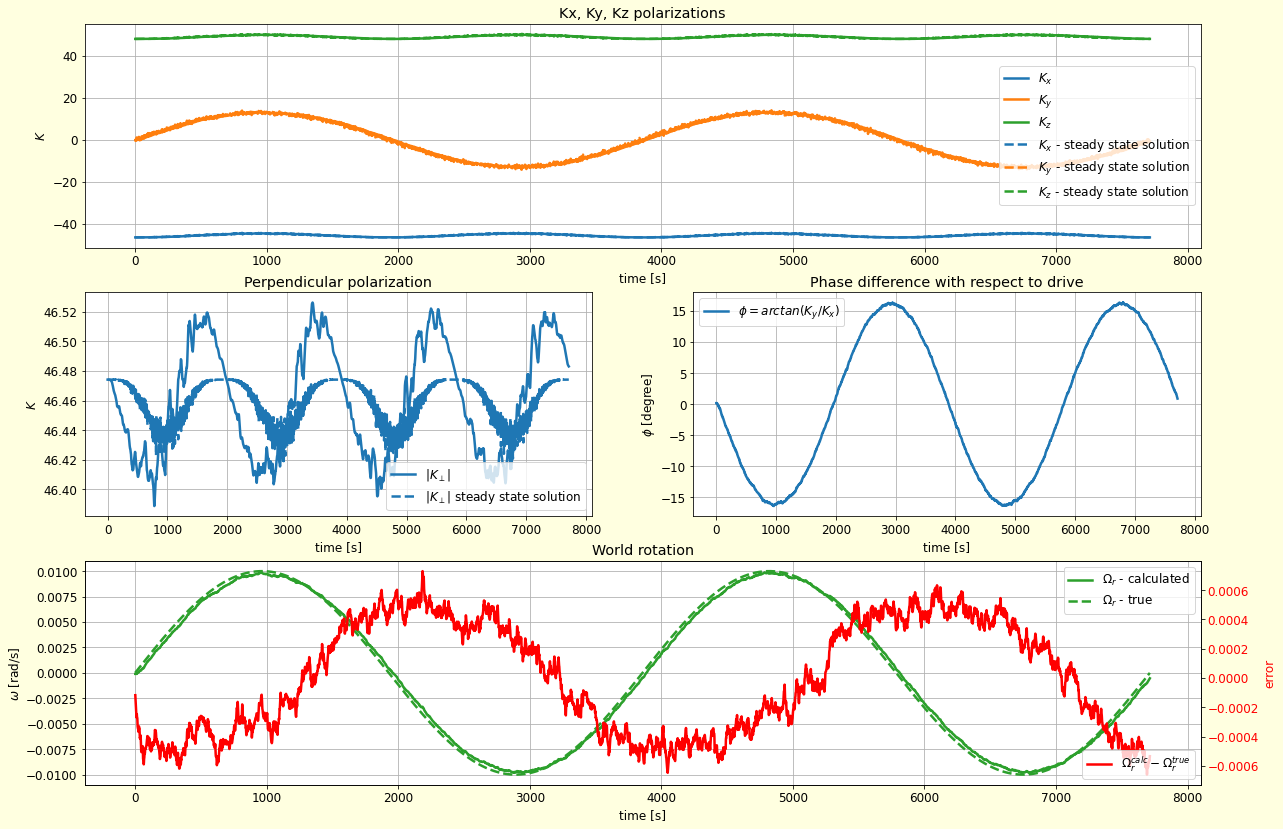


freq: 0.00032903445623126676, steps: 5999, fs: 0.9871033686938002


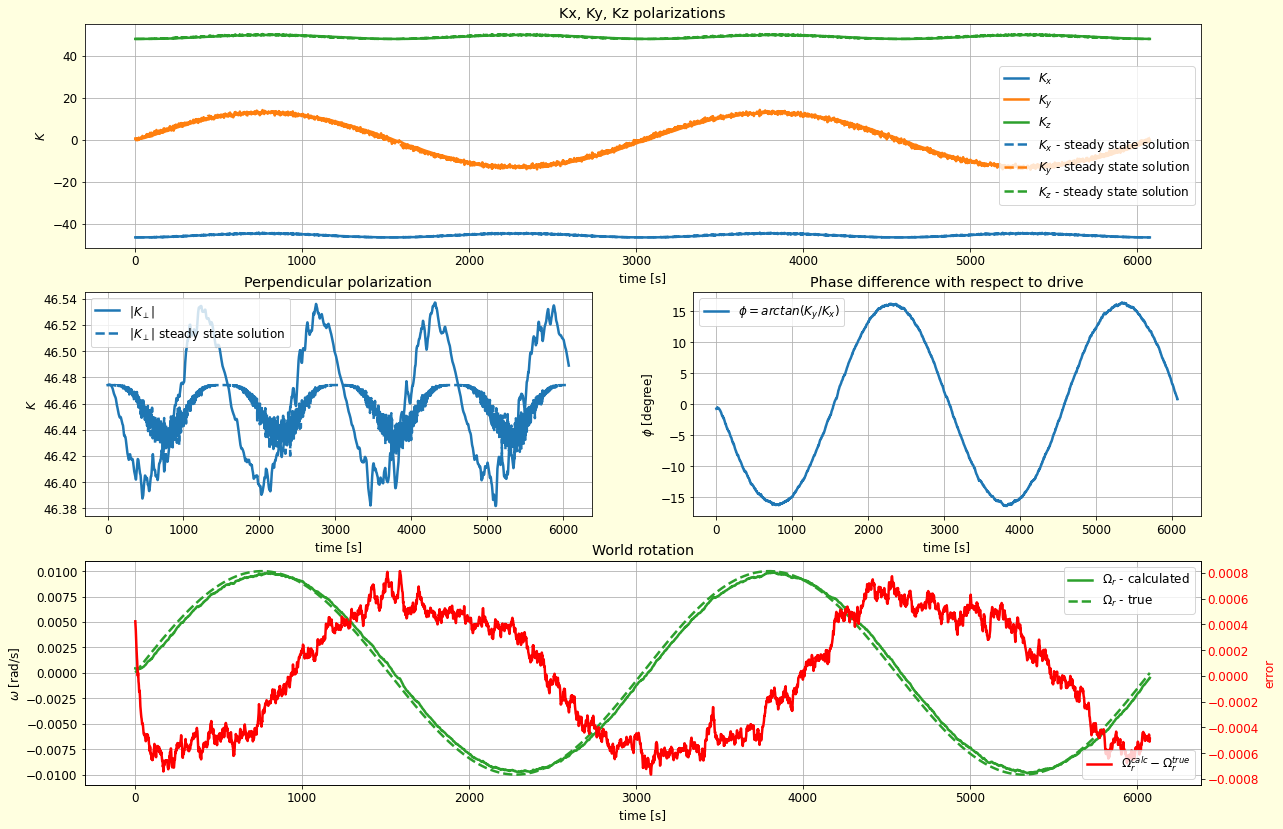


freq: 0.00041753189365604, steps: 5999, fs: 1.25259568096812


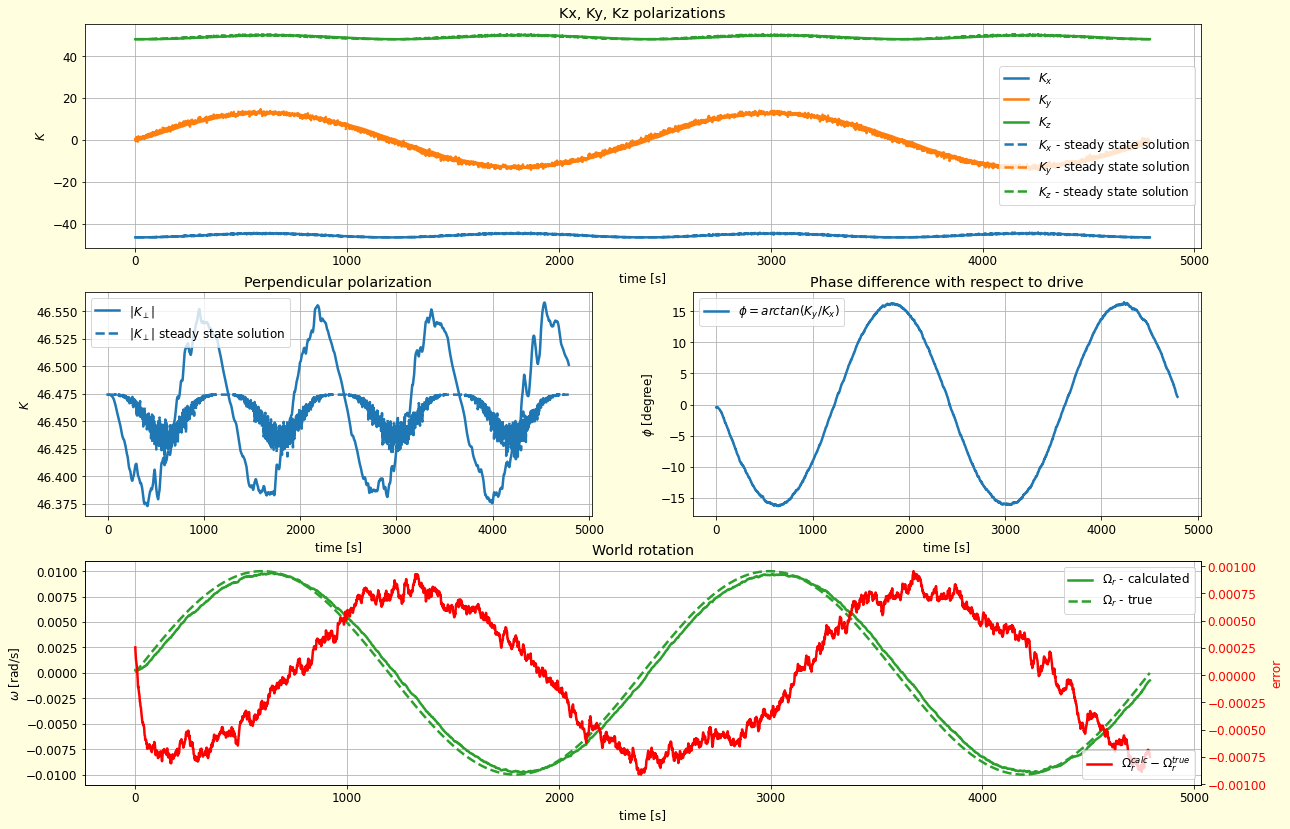


freq: 0.0005298316906283707, steps: 6000, fs: 1.5894950718851122


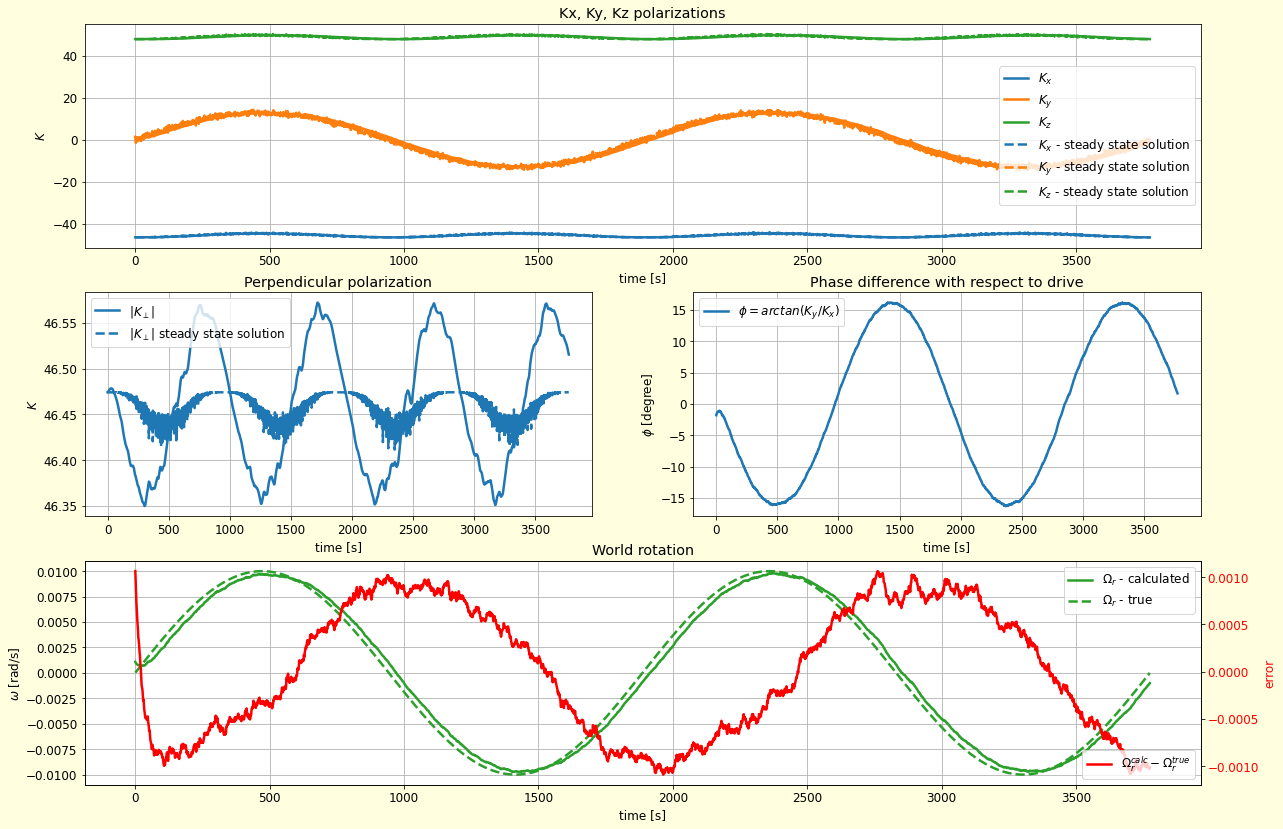


freq: 0.0006723357536499335, steps: 5999, fs: 2.0170072609498004


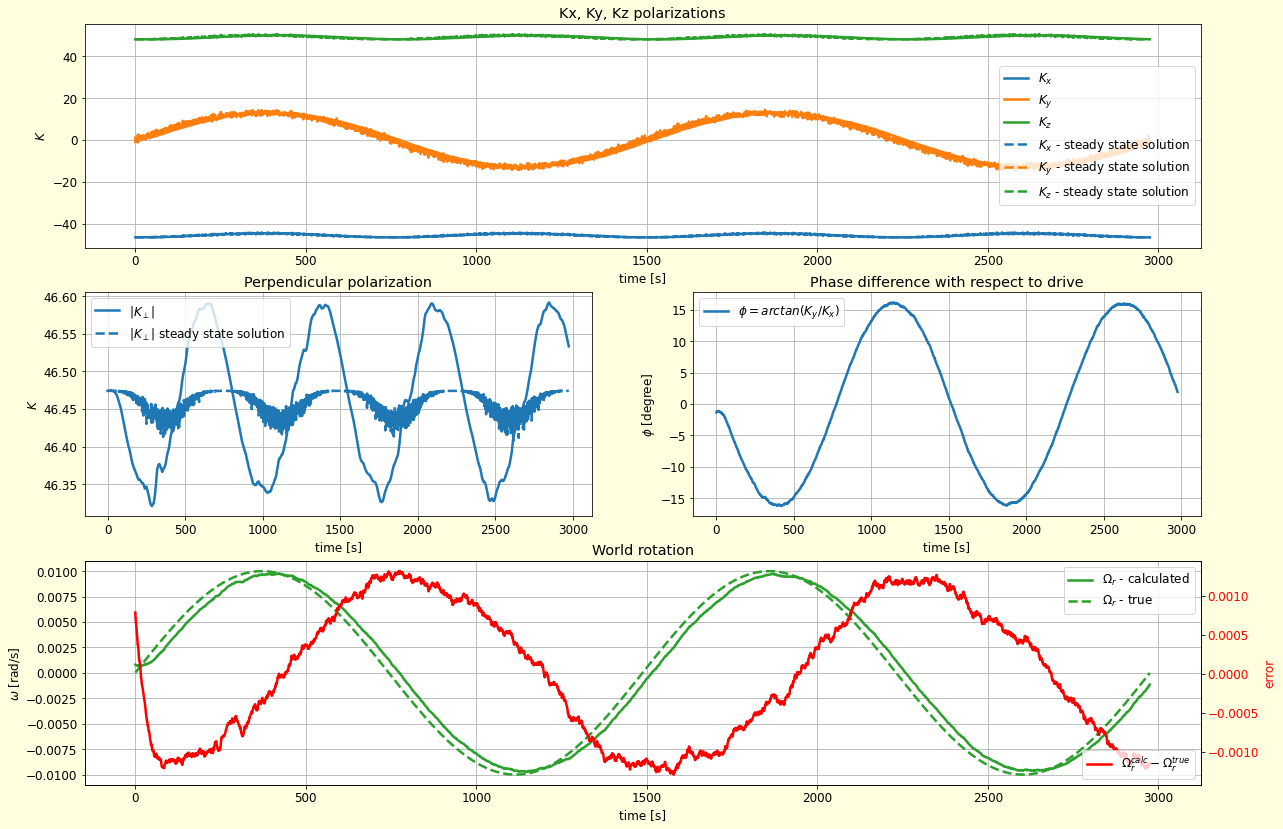


freq: 0.0008531678524172806, steps: 6000, fs: 2.5595035572518414


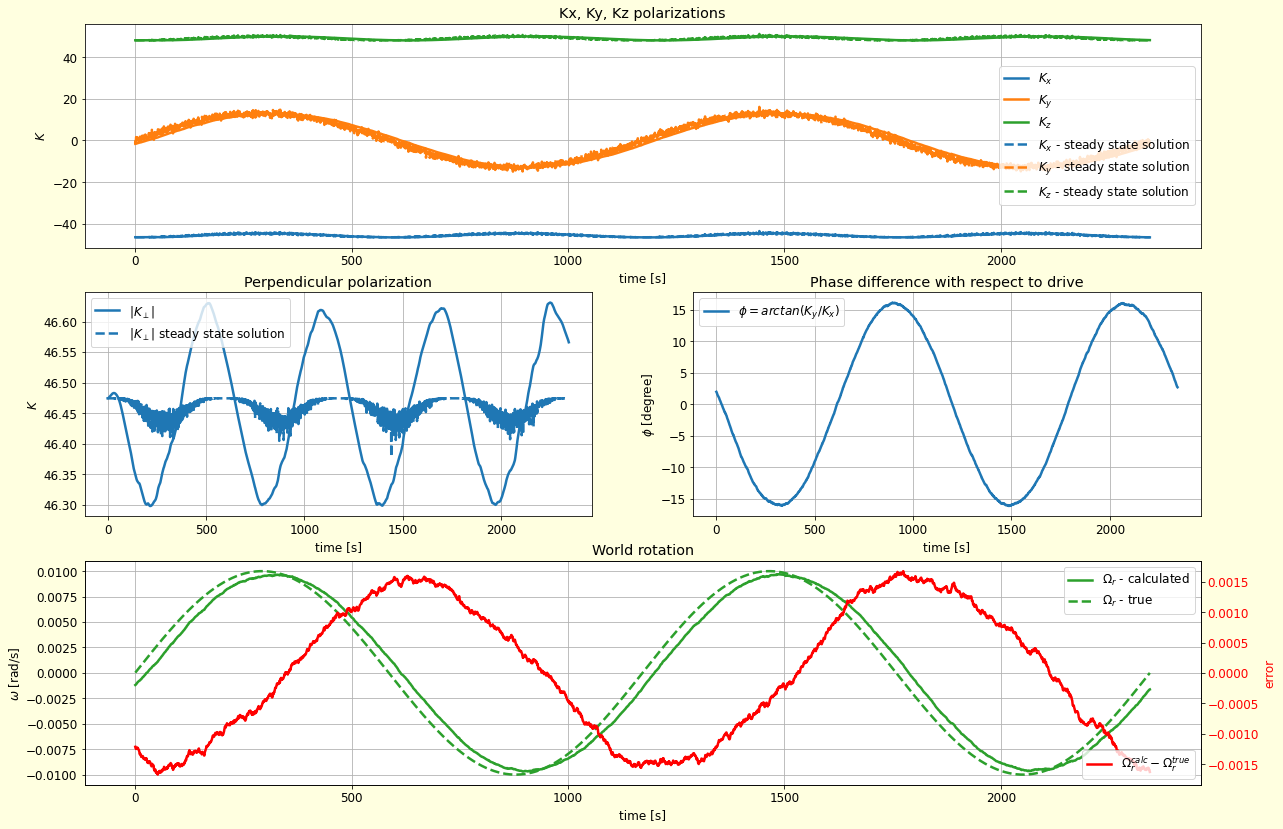


freq: 0.001082636733874054, steps: 5999, fs: 3.247910201622162


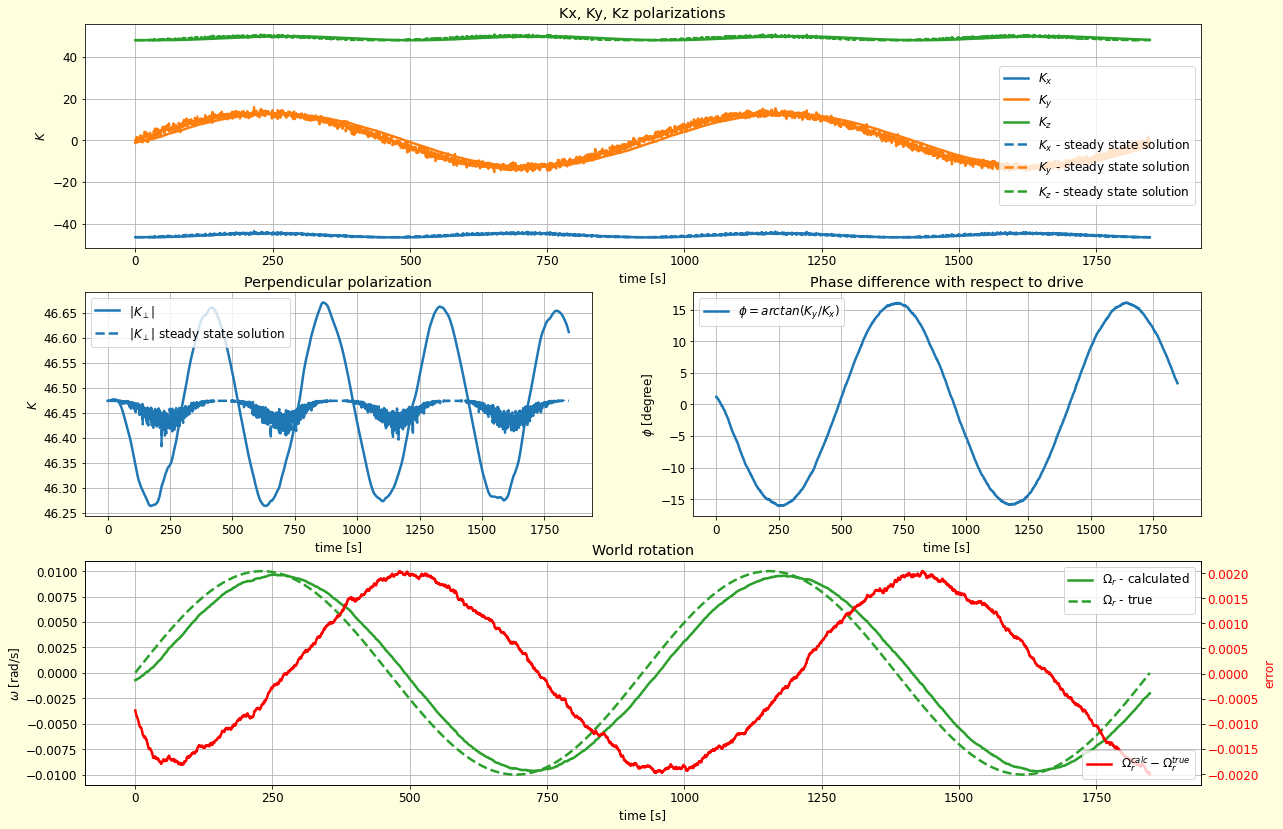


freq: 0.0013738237958832637, steps: 6000, fs: 4.121471387649792


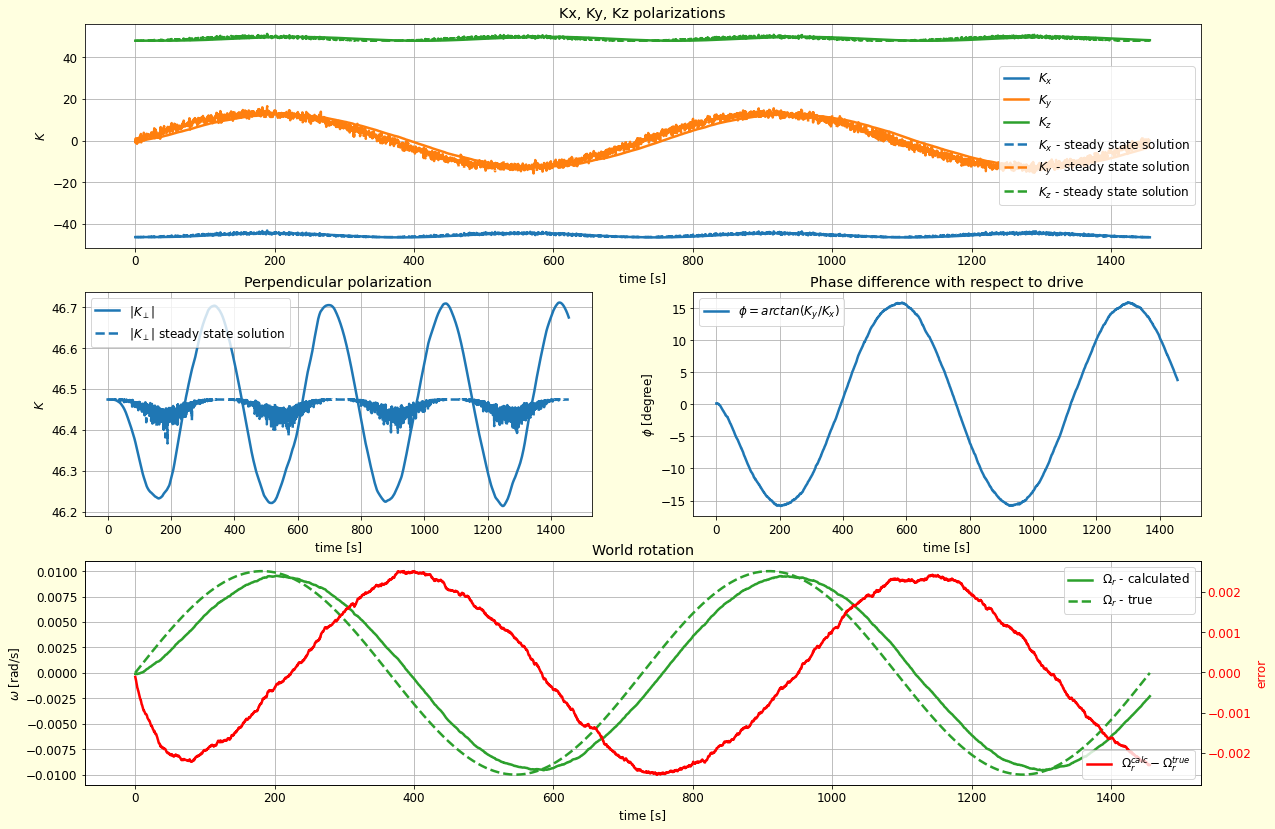


freq: 0.0017433288221999873, steps: 5999, fs: 5.229986466599962


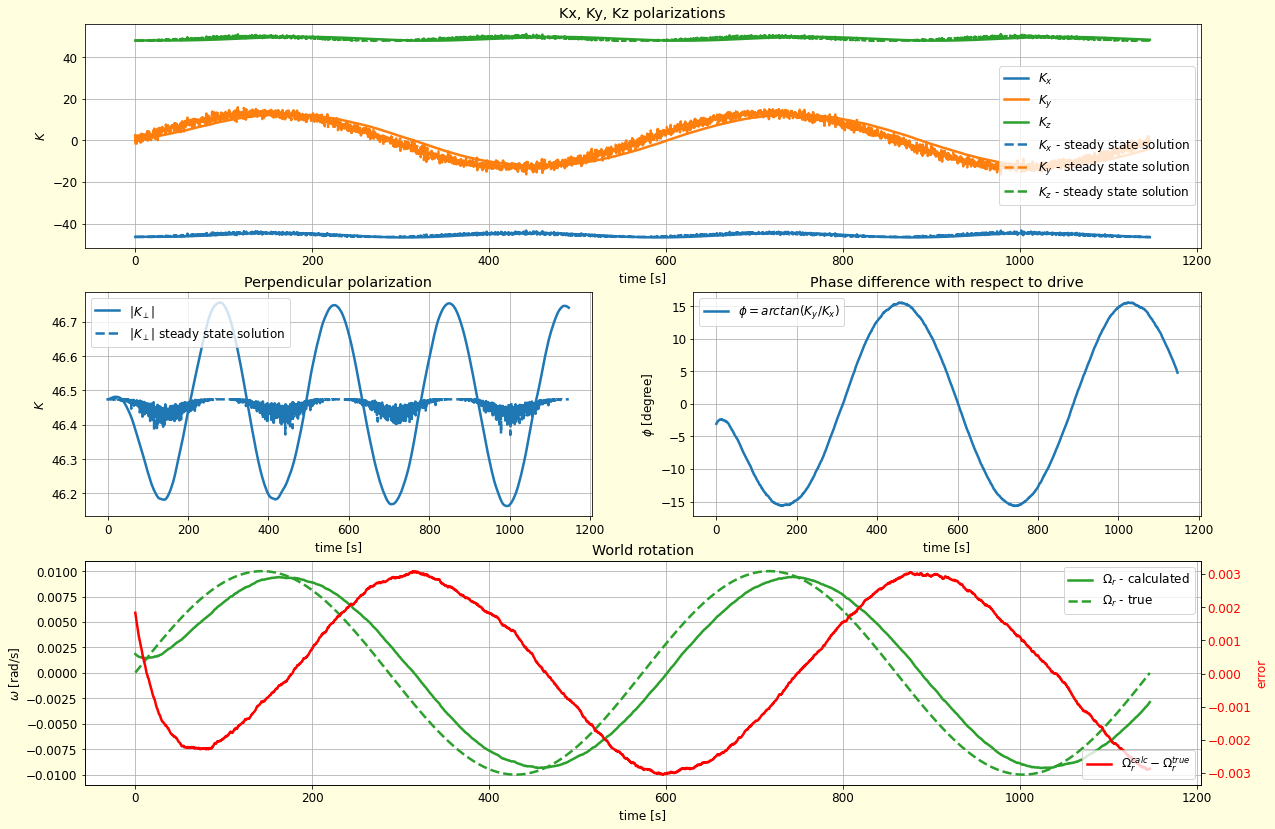


freq: 0.00221221629107045, steps: 6000, fs: 6.636648873211351


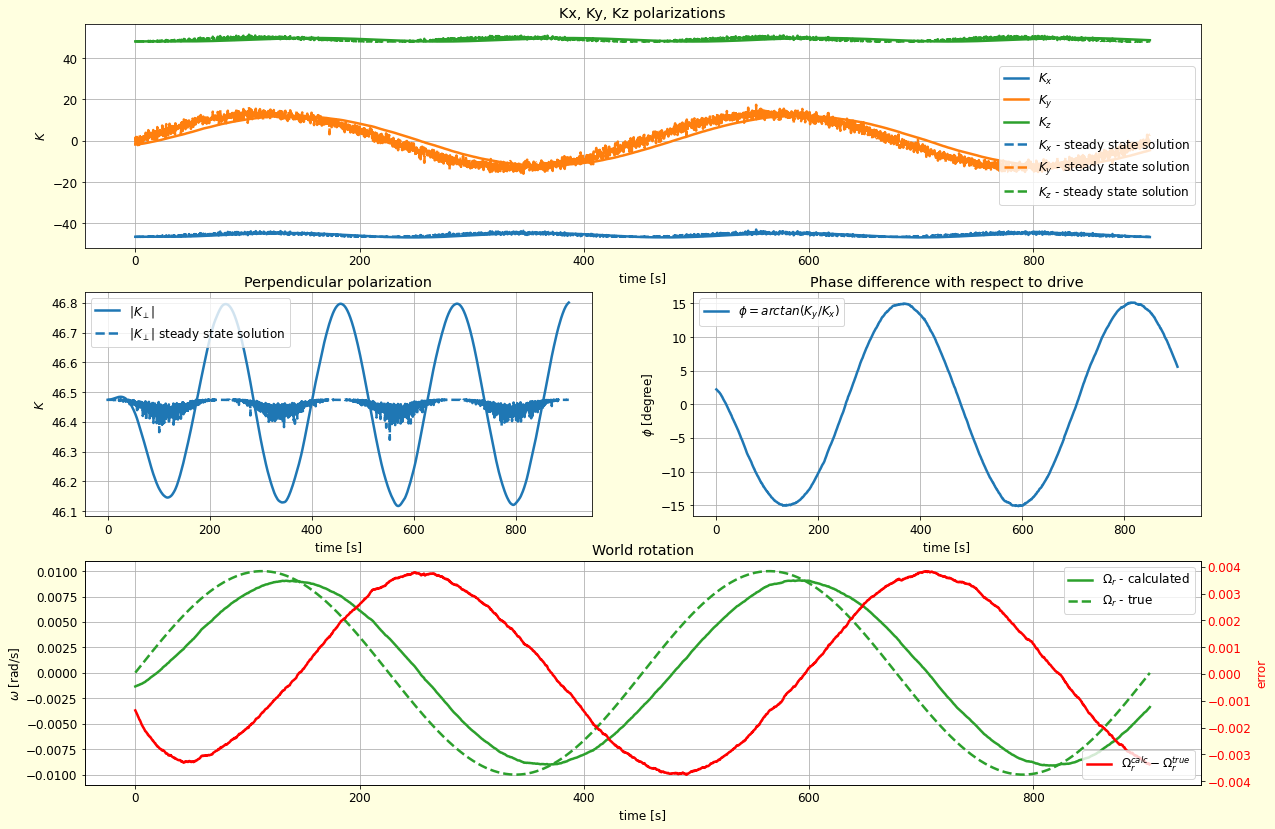


freq: 0.0028072162039411755, steps: 5999, fs: 8.421648611823526


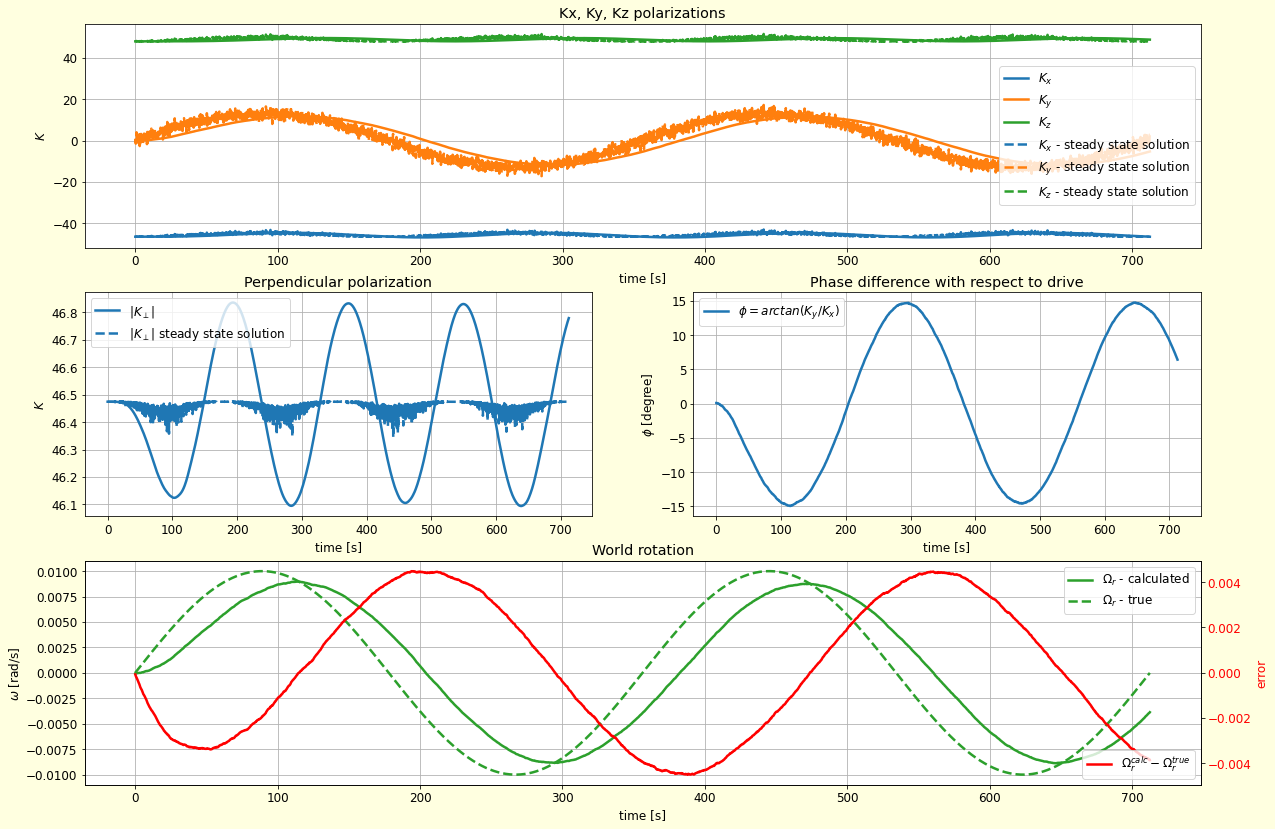


freq: 0.003562247890262444, steps: 5999, fs: 10.686743670787331


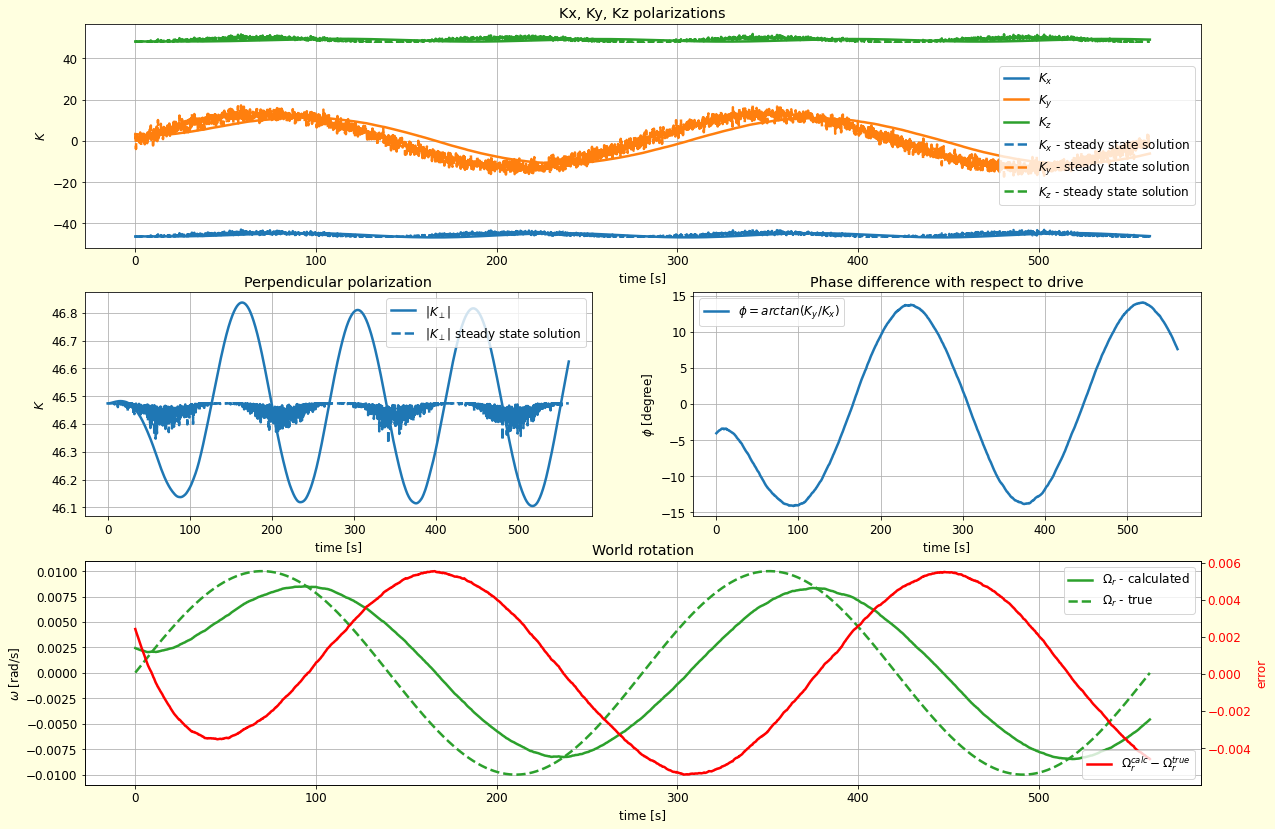


freq: 0.004520353656360241, steps: 5999, fs: 13.561060969080723


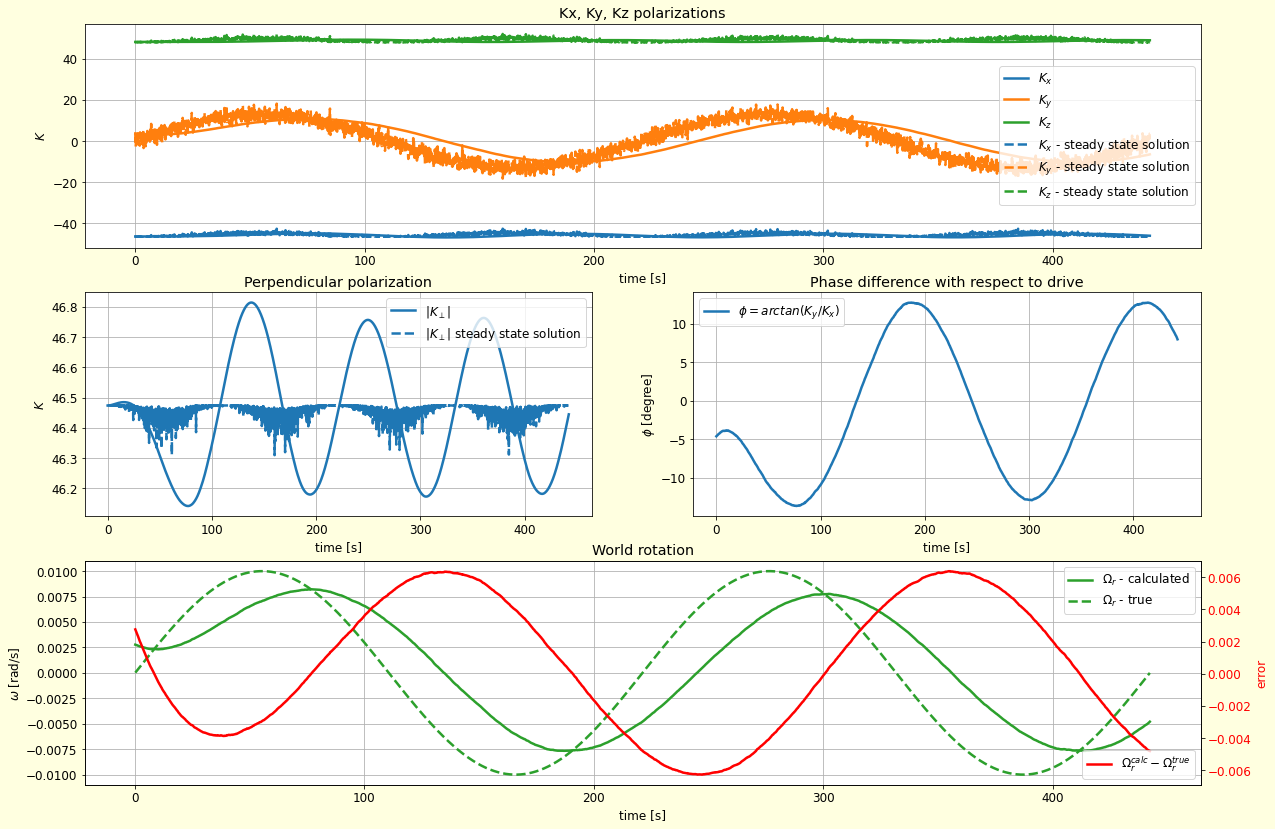


freq: 0.005736152510448681, steps: 6000, fs: 17.208457531346042


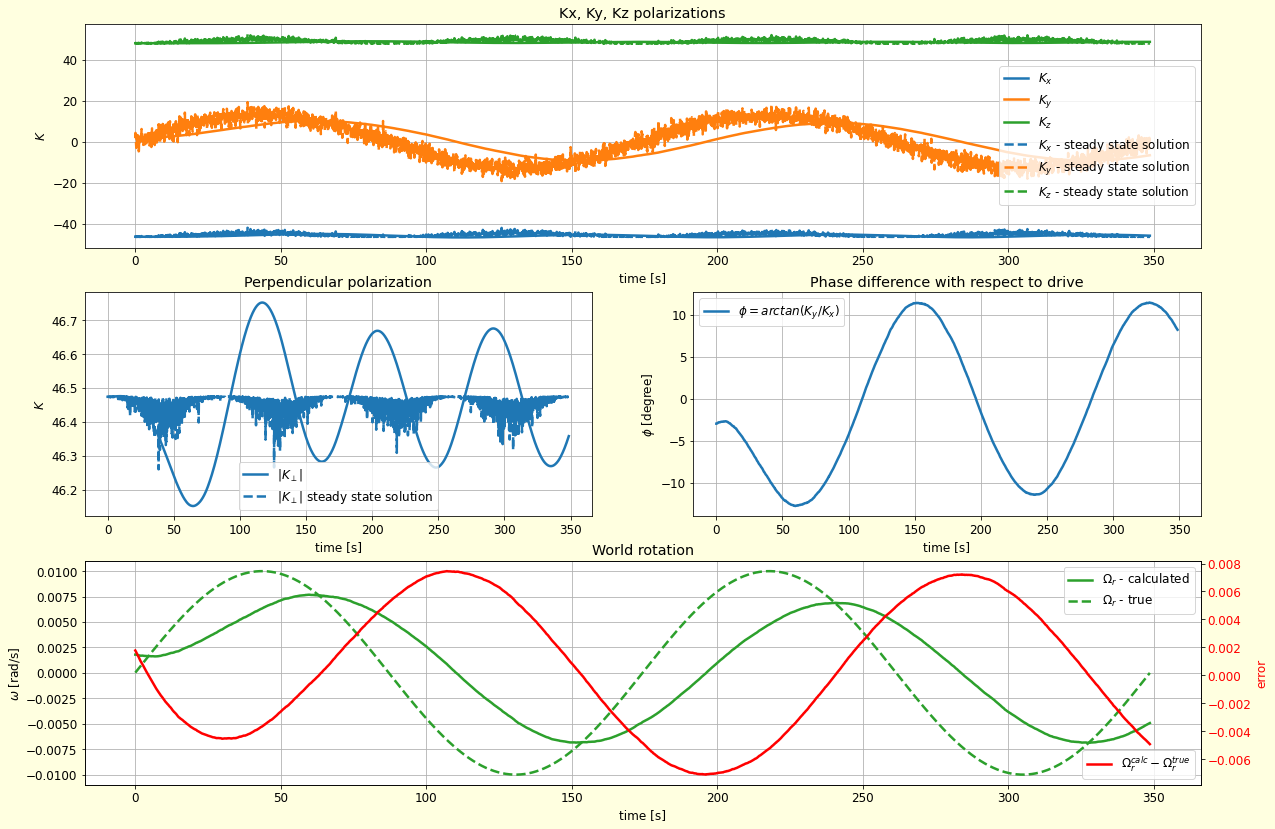


freq: 0.007278953843983146, steps: 6332, fs: 21.836861531949438


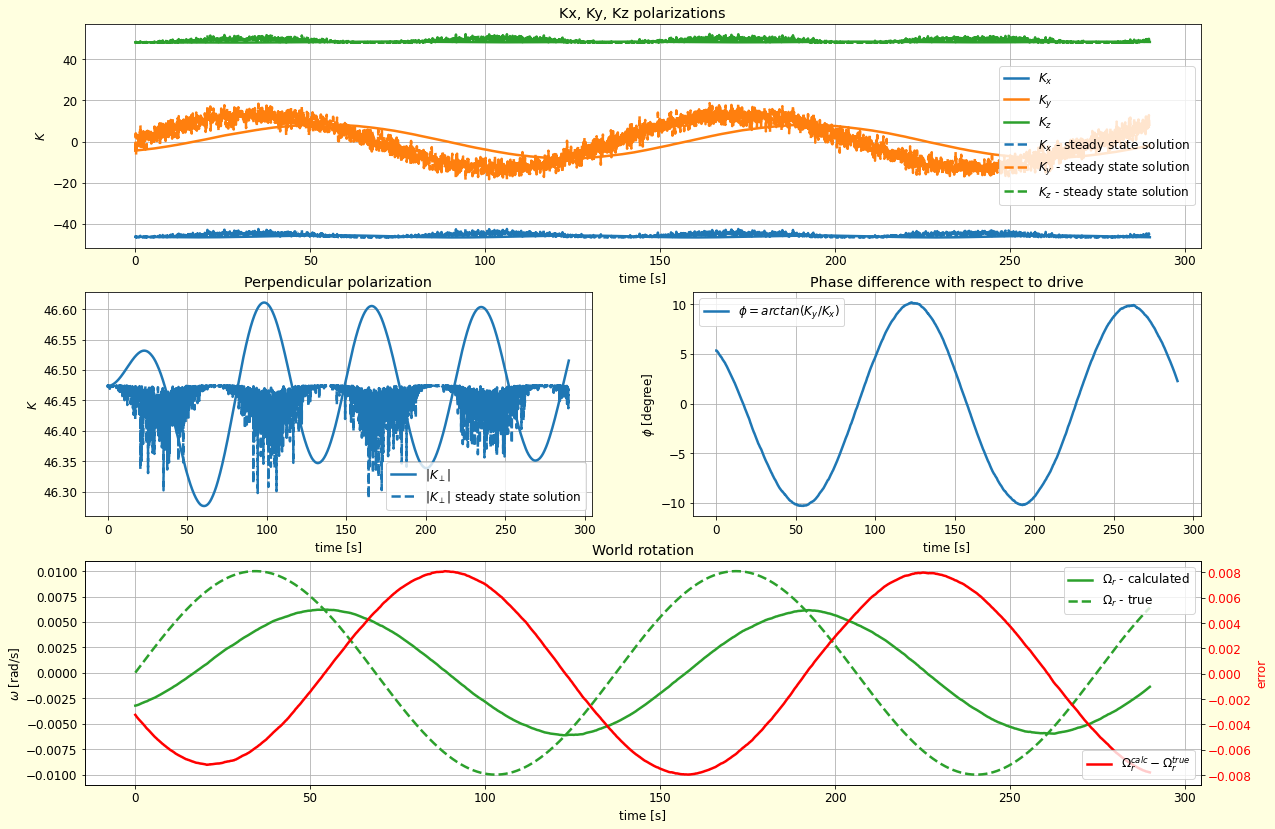


freq: 0.009236708571873866, steps: 8035, fs: 27.710125715621594


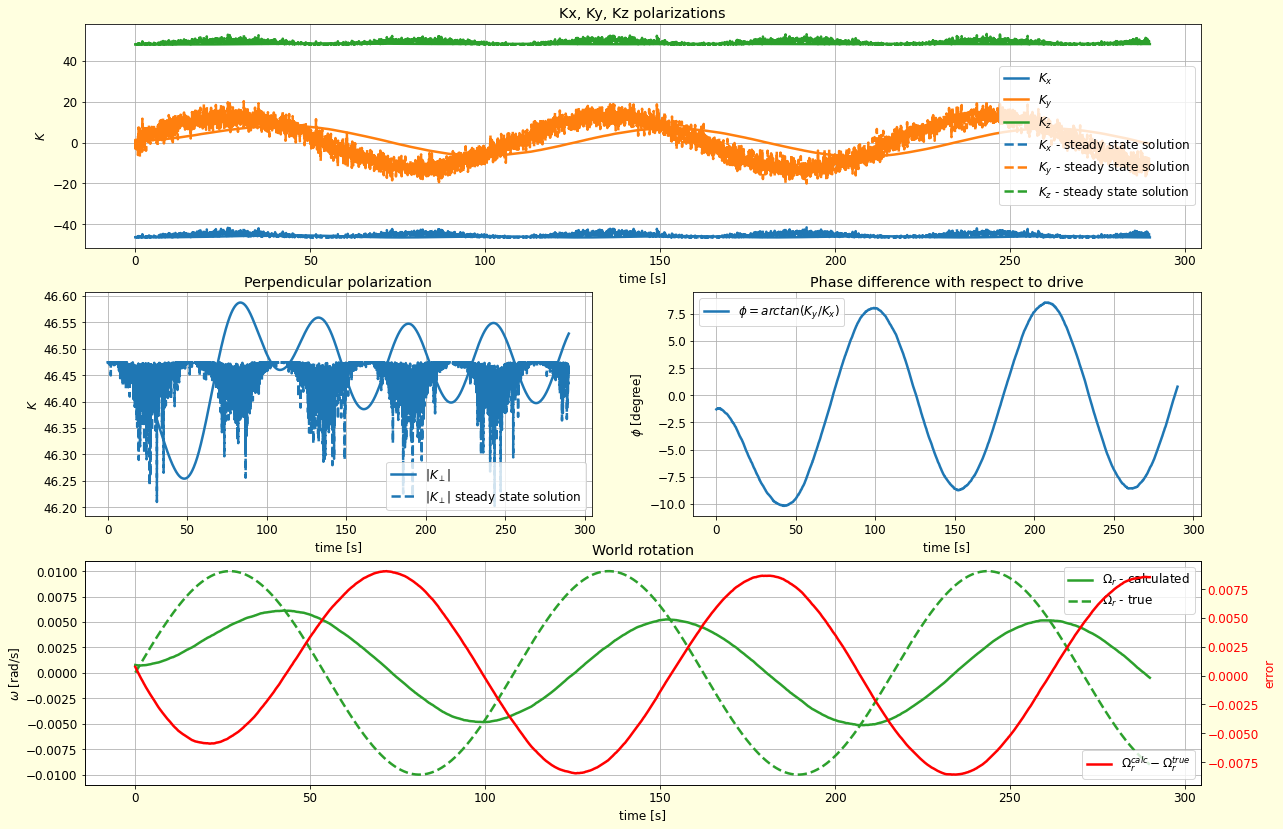


freq: 0.011721022975334805, steps: 10197, fs: 35.163068926004414


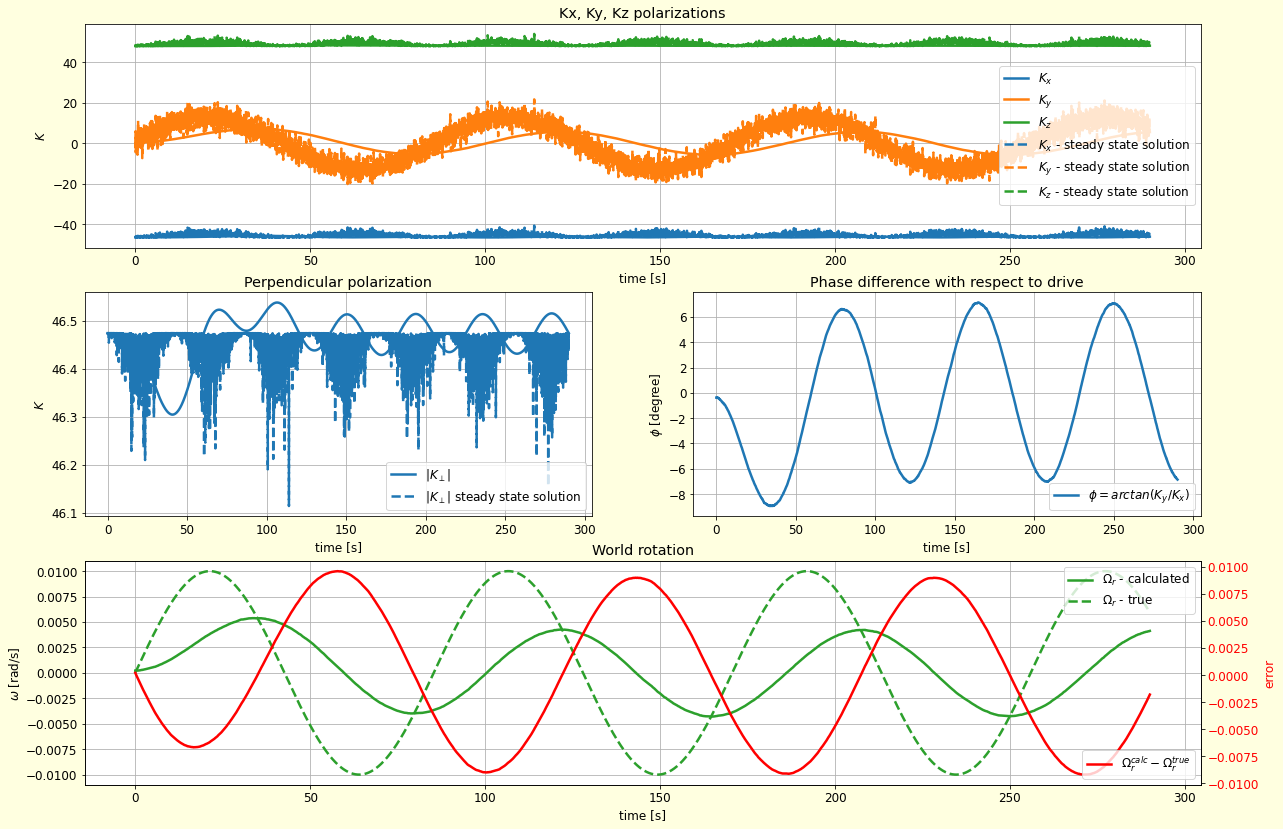


freq: 0.014873521072935119, steps: 12939, fs: 44.62056321880536


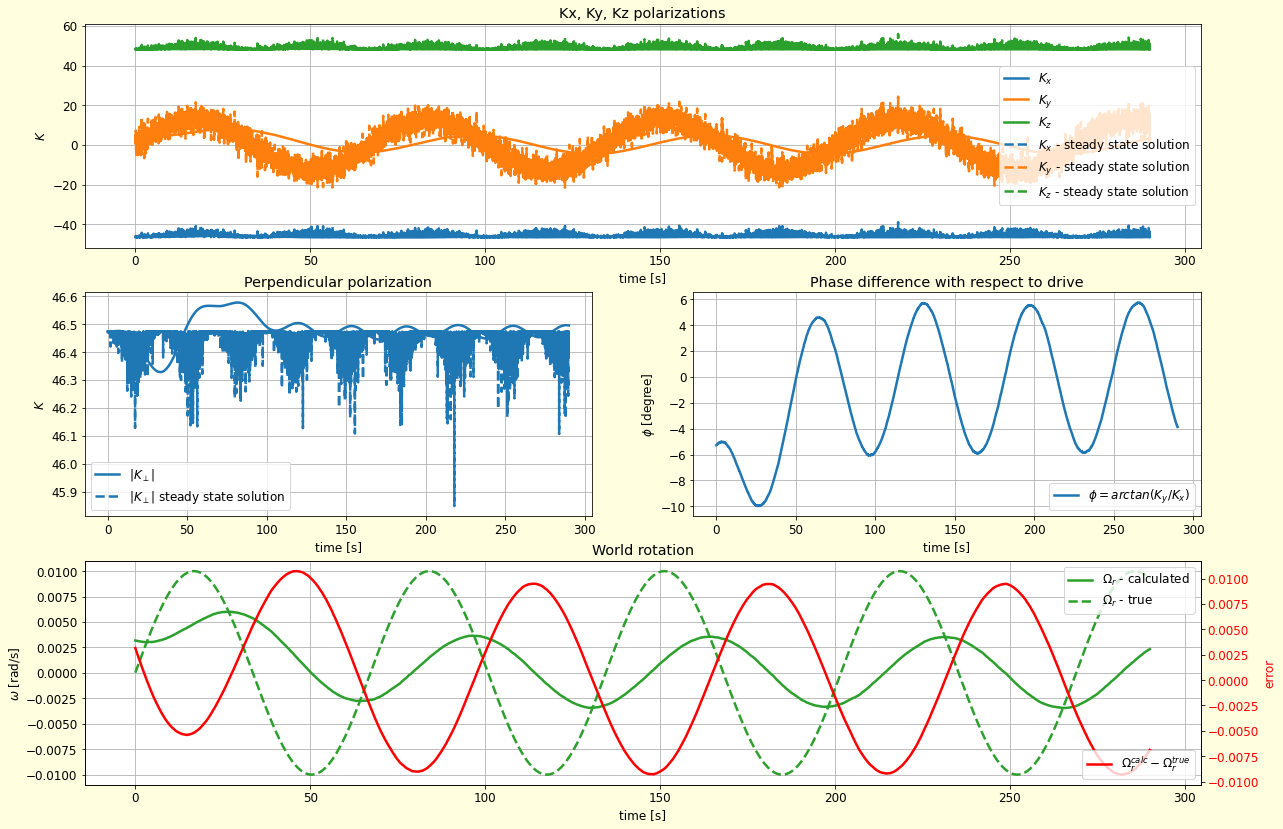


freq: 0.018873918221350976, steps: 16420, fs: 56.62175466405292


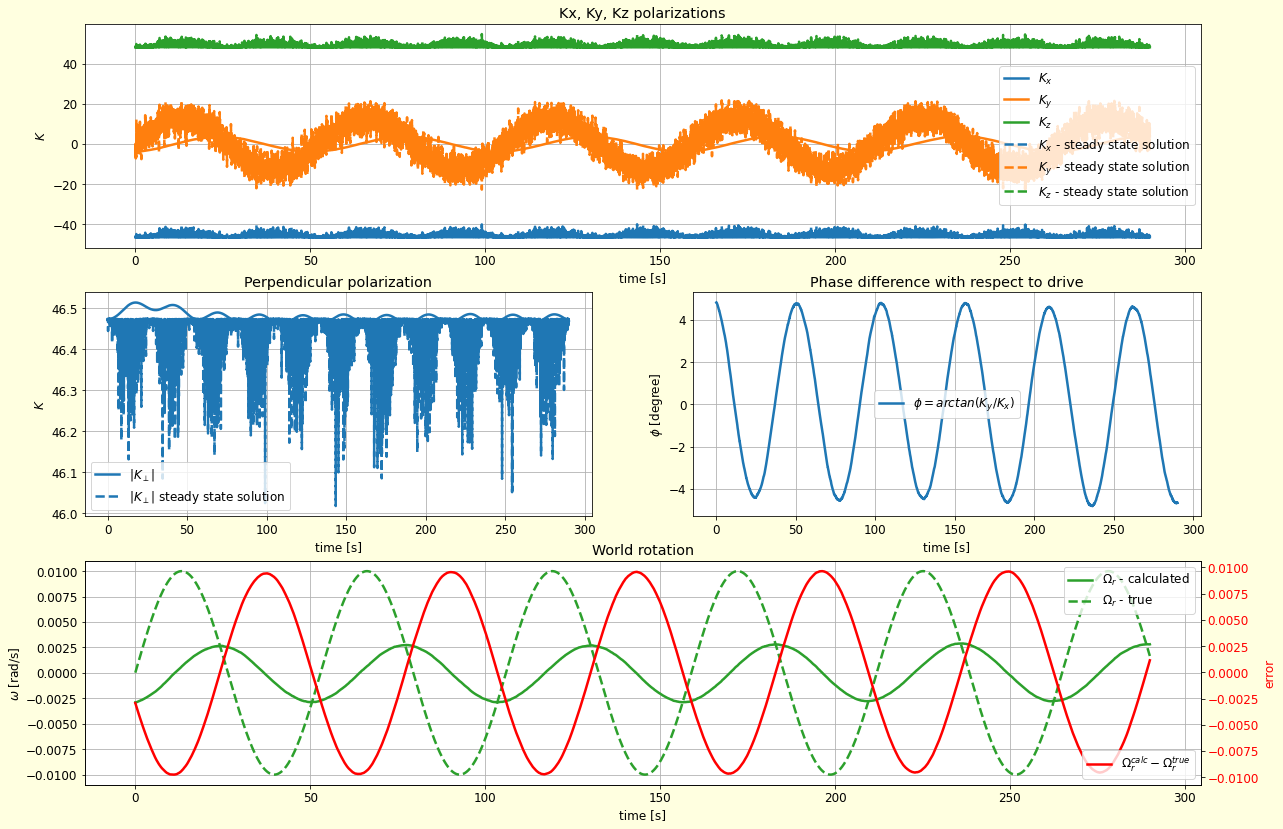


freq: 0.02395026619987486, steps: 20836, fs: 71.85079859962458


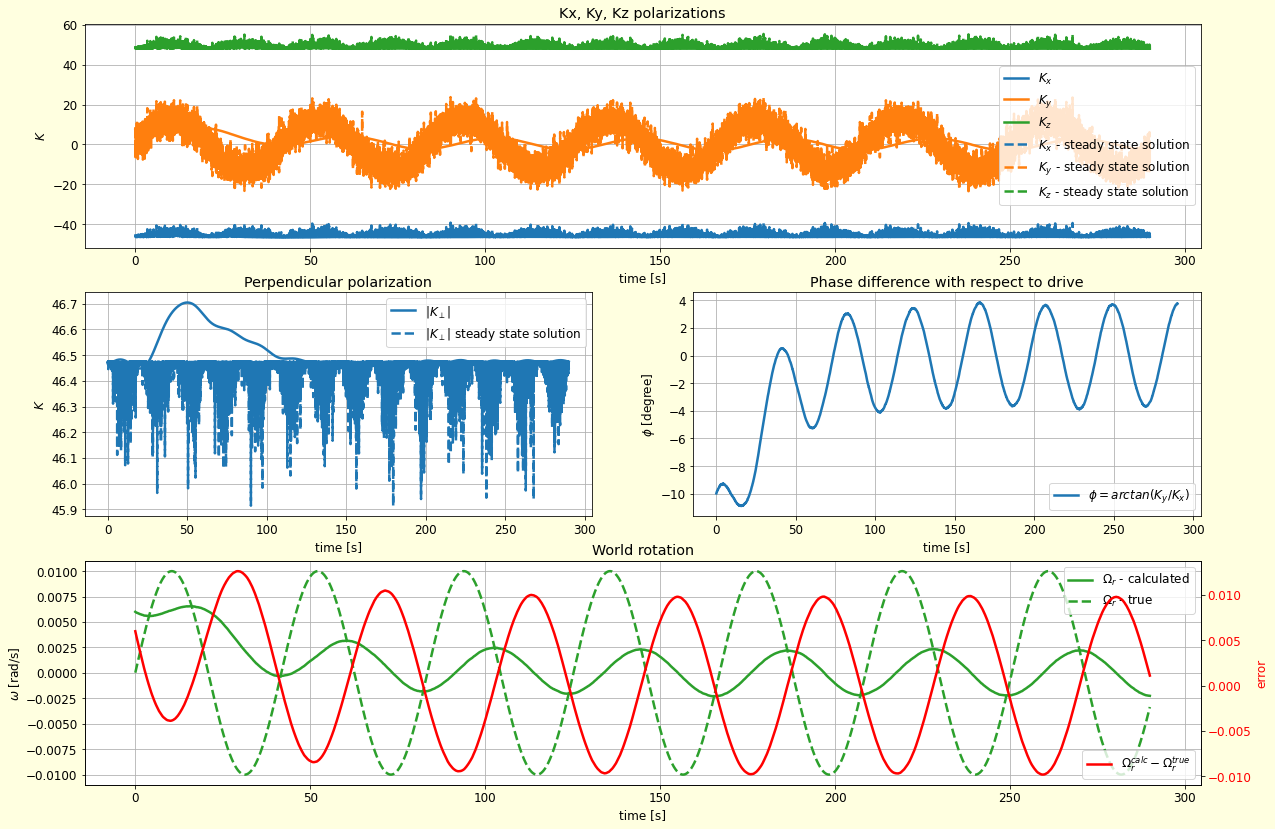


freq: 0.03039195382313198, steps: 26440, fs: 91.17586146939594


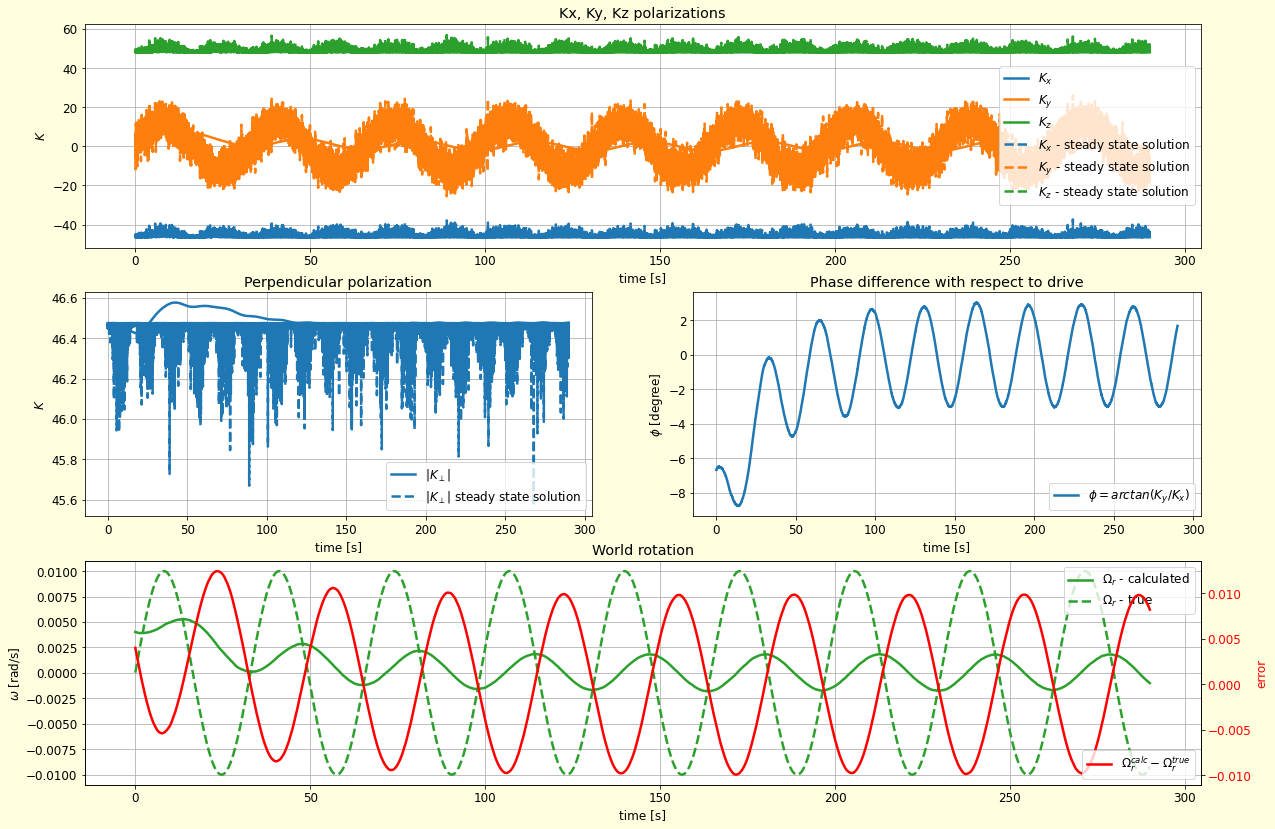


freq: 0.03856620421163472, steps: 33552, fs: 115.69861263490417


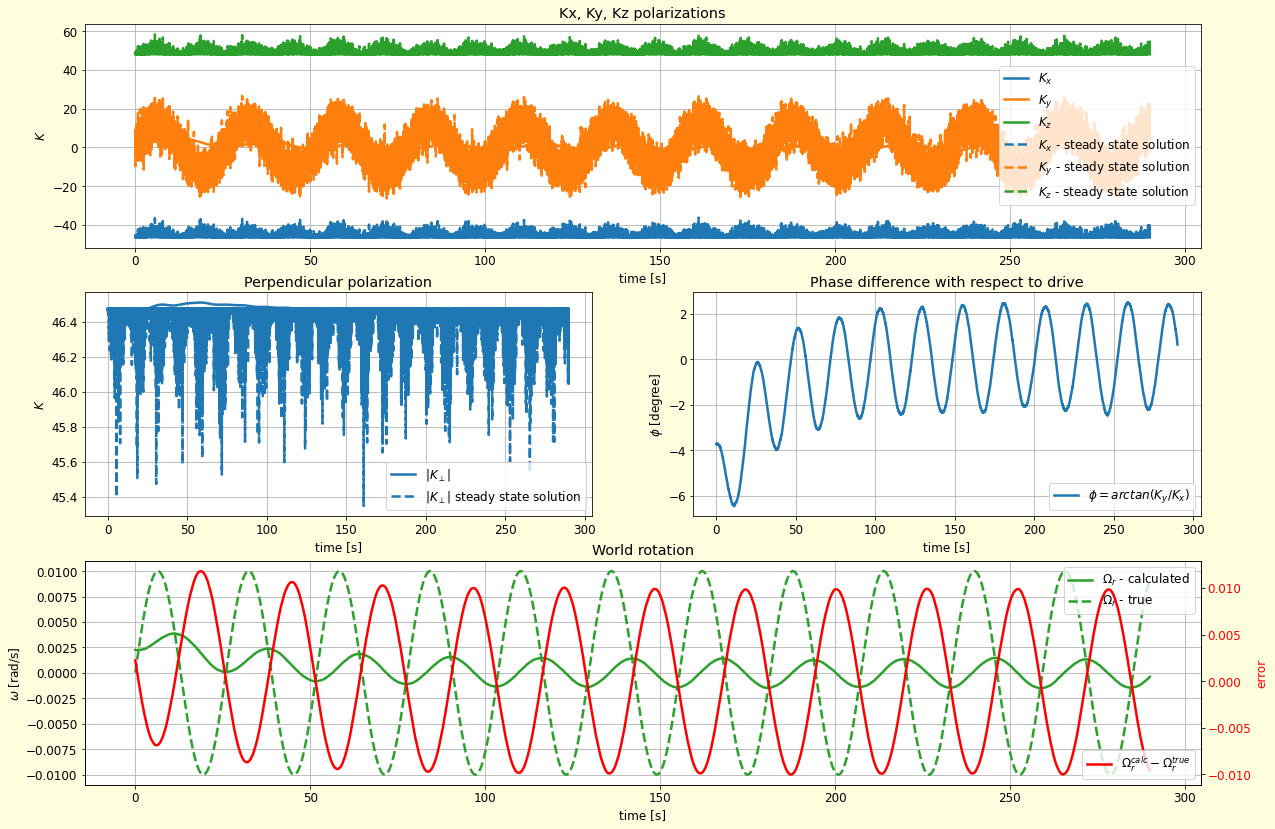


freq: 0.04893900918477494, steps: 42576, fs: 146.81702755432482


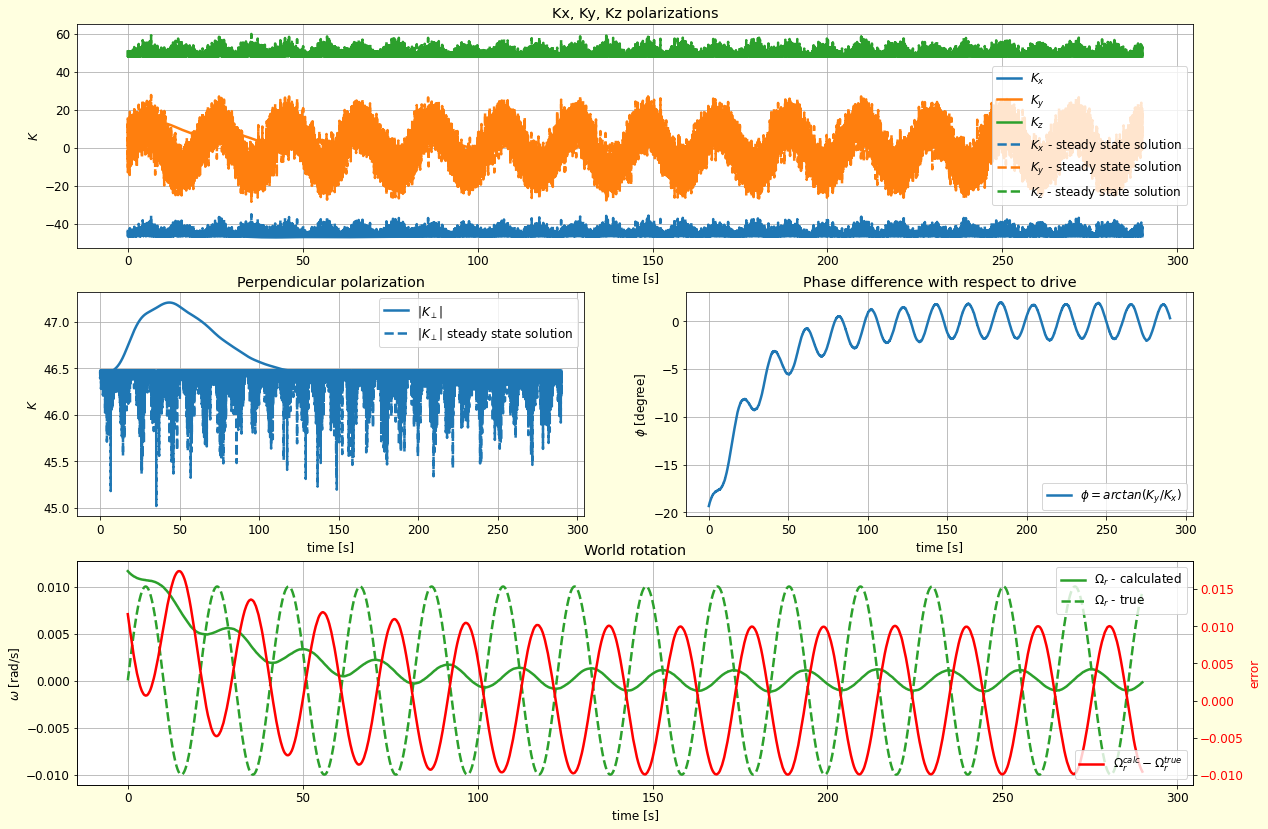


freq: 0.06210169418915616, steps: 54028, fs: 186.30508256746847


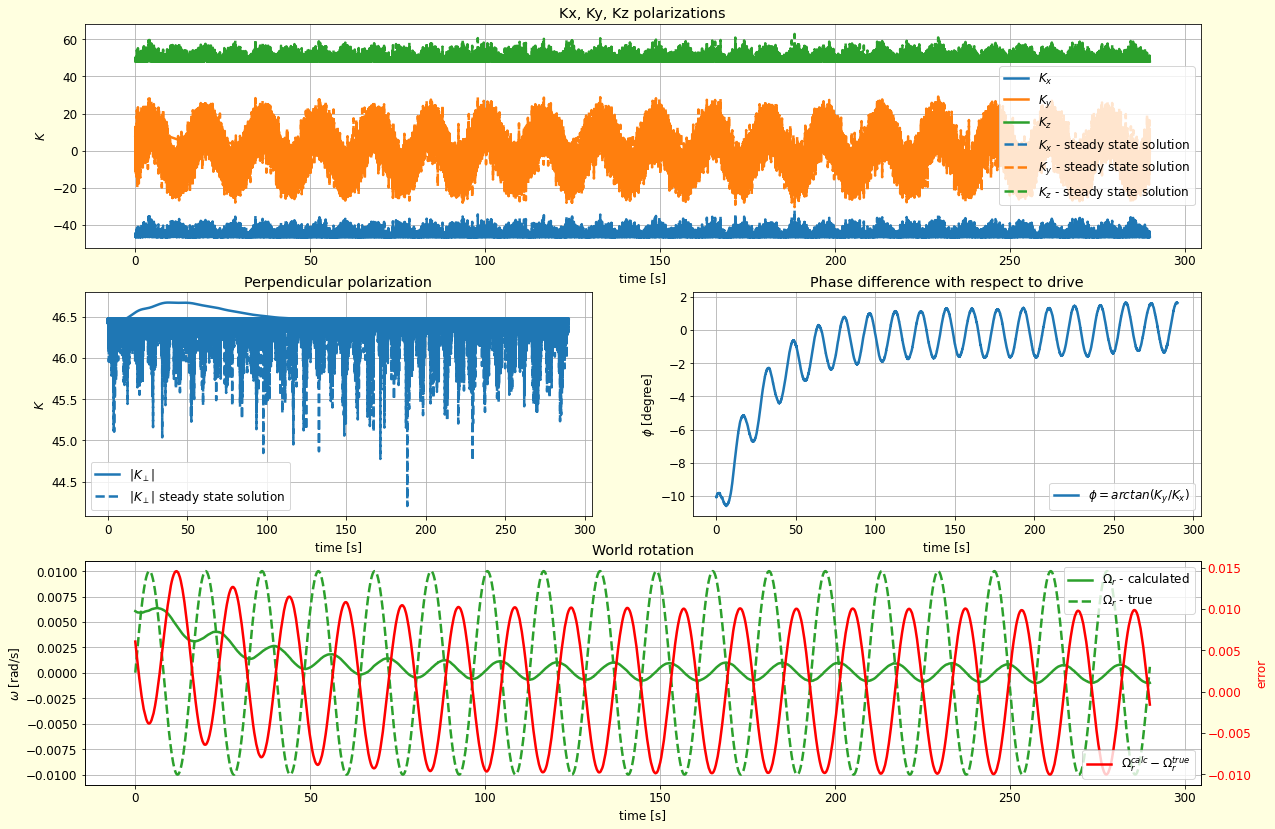


freq: 0.07880462815669913, steps: 68560, fs: 236.41388447009734


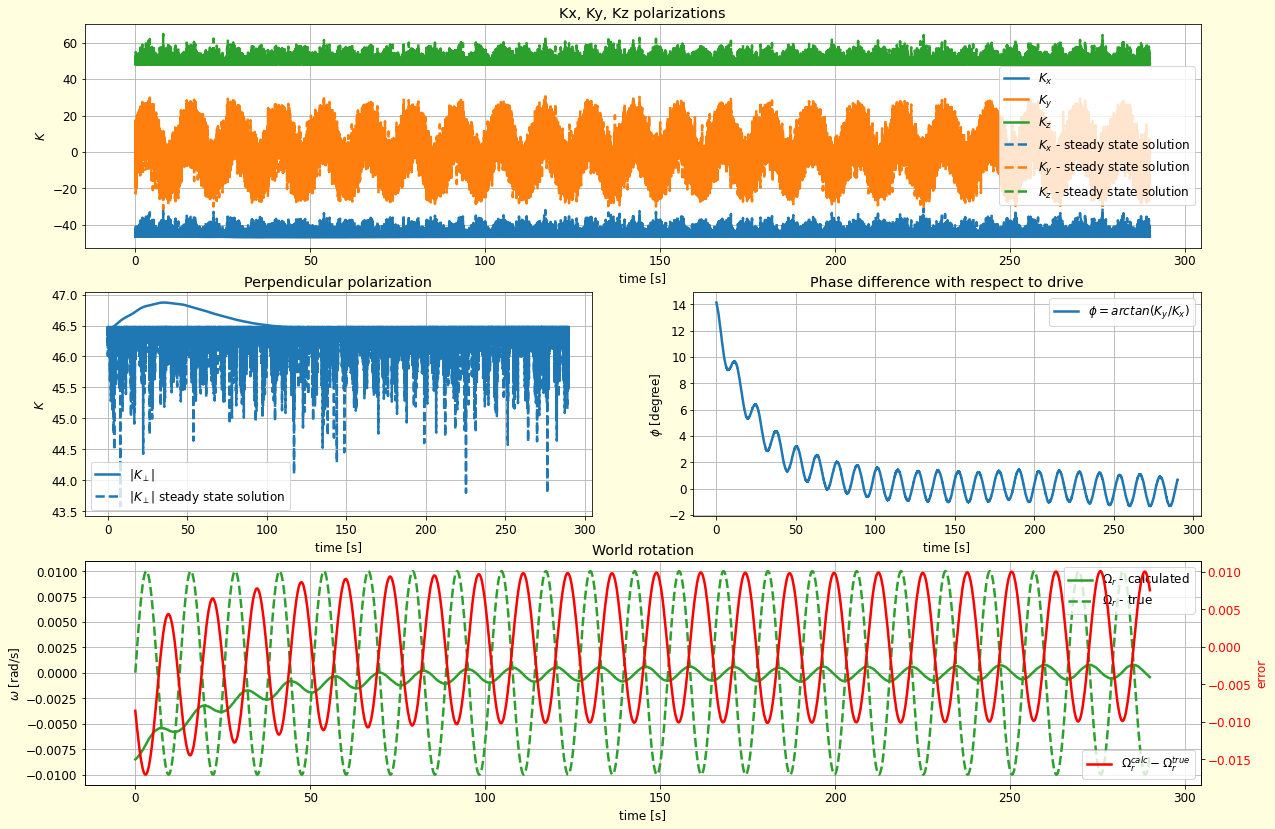


freq: 0.1, steps: 86999, fs: 300.0


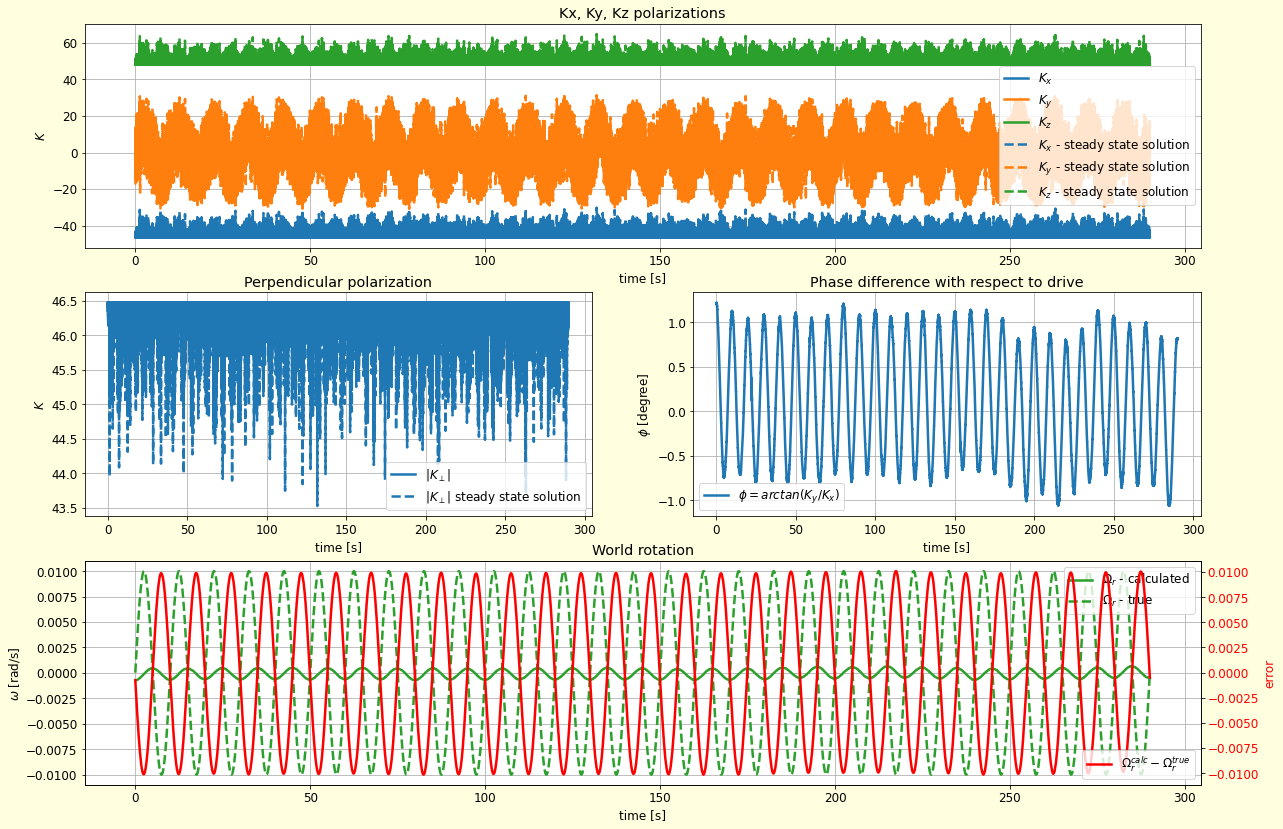

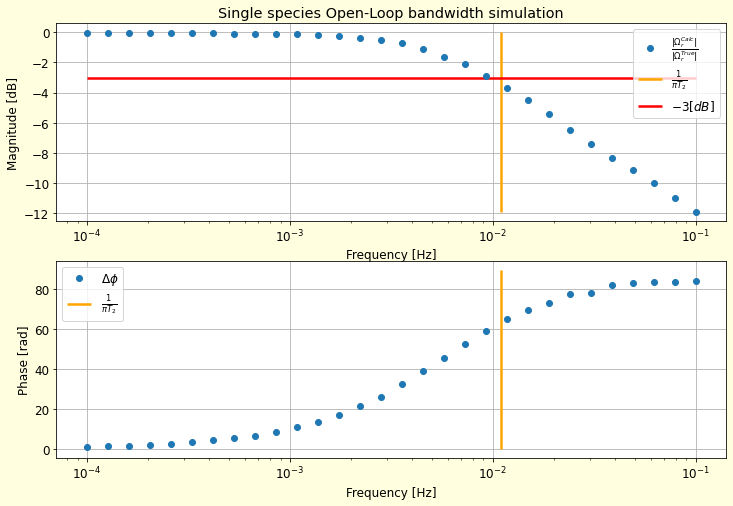

[0.9897489  0.99142669 0.99278056 0.98267085 0.98651684 0.98885707
 0.98685991 0.98057608 0.97268397 0.97041065 0.96928311 0.95741577
 0.9445277  0.91084846 0.88825842 0.84702295 0.77702376 0.6883309
 0.61673437 0.51623664 0.42567185 0.3533377  0.28665537 0.22542899
 0.18108759 0.14539928 0.12249727 0.09974633 0.07935372 0.06419143]


In [3]:
#@title Bandwidth simulation
t1 = 31 #@param {type:"slider", min:1, max:100, step:1}
t2 = 29 #@param {type:"slider", min:1, max:100, step:1}
Xenon_isotop = "129" #@param ["129", "131"]

if Xenon_isotop == '129':
    gyro = phy.G129
if Xenon_isotop == '131':
    gyro = phy.G131

frequency_list = np.logspace(-4, -1, 30)
# frequency_list = np.logspace(-3, -2, 10)
print(frequency_list)
period_list = 1 / frequency_list
points_in_period = 3000
dt = period_list / points_in_period
sampling_frequency = 1 / dt
noise_cutoff_hz = 0.1
wc = noise_cutoff_hz / (sampling_frequency / 2)
#print(wc)
_, _, amplitude_ratio = meas.single_species_Open_Loop_bandwidth_simualtion(gyro, t1, t2, Bnoise_amp=1e-7, noise_cutoff_hz=noise_cutoff_hz, points_in_period=points_in_period, freq_list=frequency_list, get_values=True, plot_steps=True)
print(amplitude_ratio)